In [12]:
%%capture
import sys
import os
# go to upper diretory
sys.path.append(os.path.abspath('./../../../'))
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pickle
from IPython.core.display import display, HTML
from sklearn.ensemble import RandomForestClassifier as RandomForest, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from Audio_Sentiment_Analysis.utils.Configuration import Configuration
from tabulate import tabulate

AUDIO_DIR = f"{os.path.abspath('./../../../')}/IEMOCAP_Dataset"
EXTRACTED_FEATURES_FILE = f"{os.path.abspath('./../../../')}/Audio_Sentiment_Analysis/iemocap/data/extracted_features_iemocap.csv"
SCALED_FEATURES_FILE = f"{os.path.abspath('./../../../')}/Audio_Sentiment_Analysis/iemocap/data/scaled_features_iemocap.csv"
CONFIG_FILE = f"{os.path.abspath('./../../../')}/Audio_Sentiment_Analysis/iemocap/config.json"
RAW_AUDIO_FILES = f"{os.path.abspath('./../../../')}/Audio_Sentiment_Analysis/iemocap/data/raw_audio_files.csv"
AUDIO_SPECTOGRAMS_DIR = './../data/spectograms/'
AUDIO_CLASSIFIER_MODEL = '../../audio_classifier_model.pkl'

config = Configuration.load_json(CONFIG_FILE)
%config InteractiveShell.ast_node_interactivity = 'all'

OneHotEncodingConfig = {'0': [1, 0], '1': [0, 1]}
plt.rcParams['figure.dpi'] = 300

In [2]:
def get_metrics(y_labels, y_pred, folds_size, ticks):
    accs = []
    i = 0
    for f_i in range(5):
        acc = round(metrics.accuracy_score(
            y_labels[i:i+folds_size[f_i]], y_pred[i:i+folds_size[f_i]]) * 100, 2)
        print(f"Accuracy for fold {f_i}: {acc}%")
        i += folds_size[f_i]
        accs.append(acc)
    
    mean_acc = f"{round(metrics.accuracy_score(y_labels, y_pred) * 100, 2)}+-{round(np.std(accs), 2)}"

    table = [
        ["Accuracy", mean_acc],
        ["F1 score macro", round(metrics.f1_score(
            y_labels, y_pred, average='macro') * 100, 2)],
        ["Precision", round(metrics.precision_score(
            y_labels, y_pred, average='macro') * 100, 2)],
        ["Recall", round(metrics.recall_score(
            y_labels, y_pred, average='macro') * 100, 2)],
        ["Matthews corrcoef", round(
            metrics.matthews_corrcoef(y_labels, y_pred), 3)],
    ]
    print()
    print(tabulate(table, headers=["Metric", "Value"]))

    cm = metrics.confusion_matrix(y_labels, y_pred)
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt="d",
                xticklabels=ticks, yticklabels=ticks)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Emotion Label")
    plt.ylabel("Real Emotion Label")
    plt.yticks(rotation=0)
    plt.show()

    return mean_acc

def categorical_cross_validation(get_new_model, used_labels, results, cv=5):
    kfold = StratifiedKFold(n_splits=cv, shuffle=True, random_state=1)
    
    X = df.iloc[:,8:]
    y = df.iloc[:,4:5]
    all_y_pred = []
    all_y_labels = []
    folds_size = []

    fold_no = 1
    for train, test in kfold.split(X, y):
        model = get_new_model()
        
        X_train, X_test = X.iloc[train], X.iloc[test]
        y_train, y_test = y.iloc[train], y.iloc[test]
        folds_size.append(len(y_test))
        
        model.fit(X_train, y_train.values.ravel())

        y_pred = model.predict(X_test)
        all_y_pred.extend(y_pred)
        y_test = np.reshape(y_test.values, y_pred.shape)
        all_y_labels.extend(y_test)

        fold_no = fold_no + 1

    results.append([used_labels, get_metrics(all_y_labels, all_y_pred, folds_size, used_labels.split(", ")), len(df)])

    return results

results = []

Angry, Sad, Neutral, Happy+Excited

Number of Audio Files: 5531


,,Emotion
,,count
Emotion,Emotion_Id,
angry,0,1103
excited,1,1041
happy,1,595
neutral,3,1708
sad,2,1084


Accuracy for fold 0: 60.07%
Accuracy for fold 1: 60.4%
Accuracy for fold 2: 60.67%
Accuracy for fold 3: 61.03%
Accuracy for fold 4: 59.58%

Metric             Value
-----------------  ----------
Accuracy           60.35+-0.5
F1 score macro     61.02
Precision          62.07
Recall             60.59
Matthews corrcoef  0.463


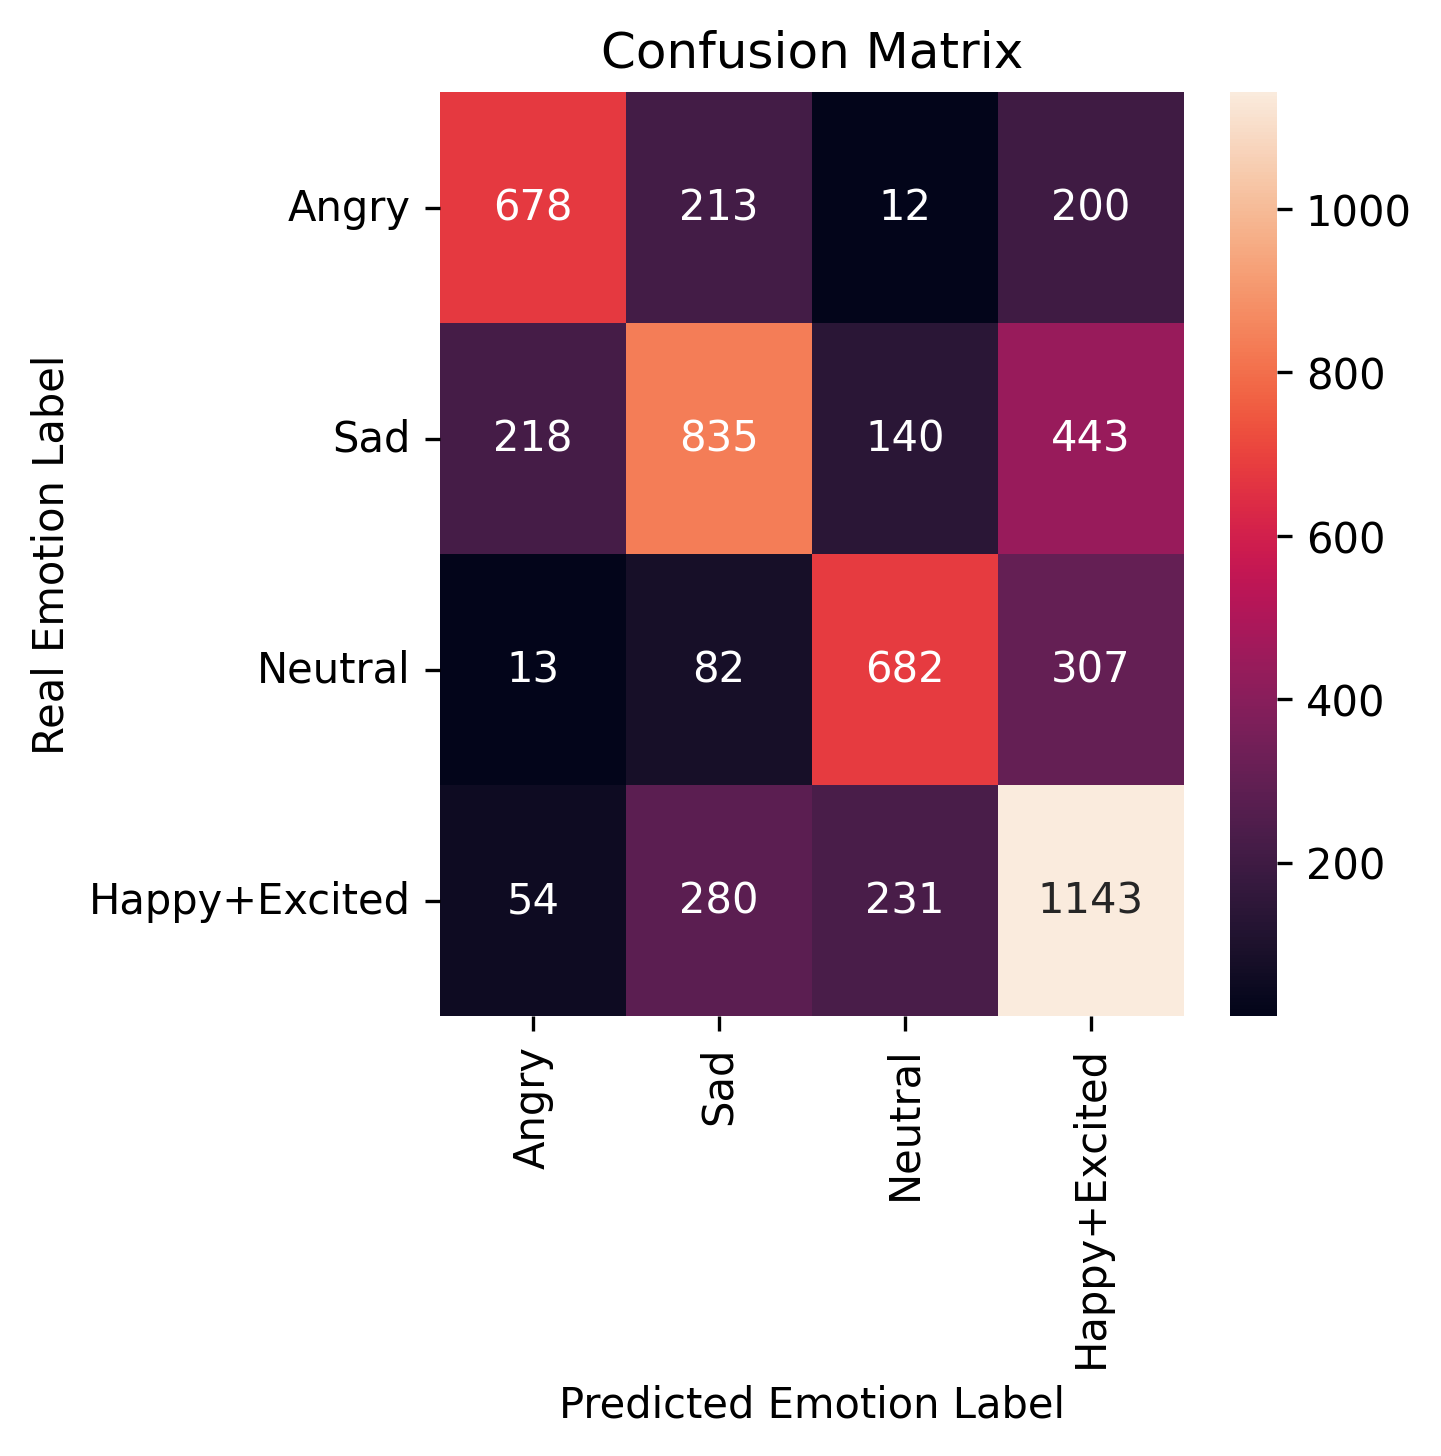

In [18]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)
df = df.sort_values(['Emotion_Id', 'Gender'], ascending = (True, True))
df = df.set_index('File')
df = df[df['Emotion'].isin({'angry', 'neutral', 'happy', 'excited', 'sad'})]
df.loc[df['Emotion_Id'] == 5, 'Emotion_Id'] = 1

print(f"Number of Audio Files: {df.shape[0]}")
df.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']})

def get_new_model():
    return RandomForest(n_estimators=512, n_jobs=-1, random_state=1)
results = categorical_cross_validation(get_new_model, "Angry, Sad, Neutral, Happy+Excited", results)

In [13]:
# Exporting models
df = pd.read_csv(EXTRACTED_FEATURES_FILE)
df = df.sort_values(['Emotion_Id', 'Gender'], ascending = (True, True))
df = df.set_index('File')
df = df[df['Emotion'].isin({'angry', 'neutral', 'happy', 'excited', 'sad'})]
df.loc[df['Emotion_Id'] == 5, 'Emotion_Id'] = 1

model = RandomForest(n_estimators=512, n_jobs=-1, random_state=1)
model.fit(df.iloc[:,8:].values, df.iloc[:,4:5].values.ravel())
with open(AUDIO_CLASSIFIER_MODEL, 'wb') as file:
    pickle.dump(model, file)

RandomForestClassifier(n_estimators=512, n_jobs=-1, random_state=1)

Angry+Sad, Neutral+Happy+Excited

Number of Audio Files: 5531


,,Emotion
,,count
Emotion,Emotion_Id,
angry,0,1103
excited,1,1041
happy,1,595
neutral,1,1708
sad,0,1084


Accuracy for fold 0: 73.8%
Accuracy for fold 1: 74.05%
Accuracy for fold 2: 74.5%
Accuracy for fold 3: 75.14%
Accuracy for fold 4: 72.15%

Metric             Value
-----------------  ----------
Accuracy           73.93+-1.0
F1 score macro     71.34
Precision          73.43
Recall             70.73
Matthews corrcoef  0.441


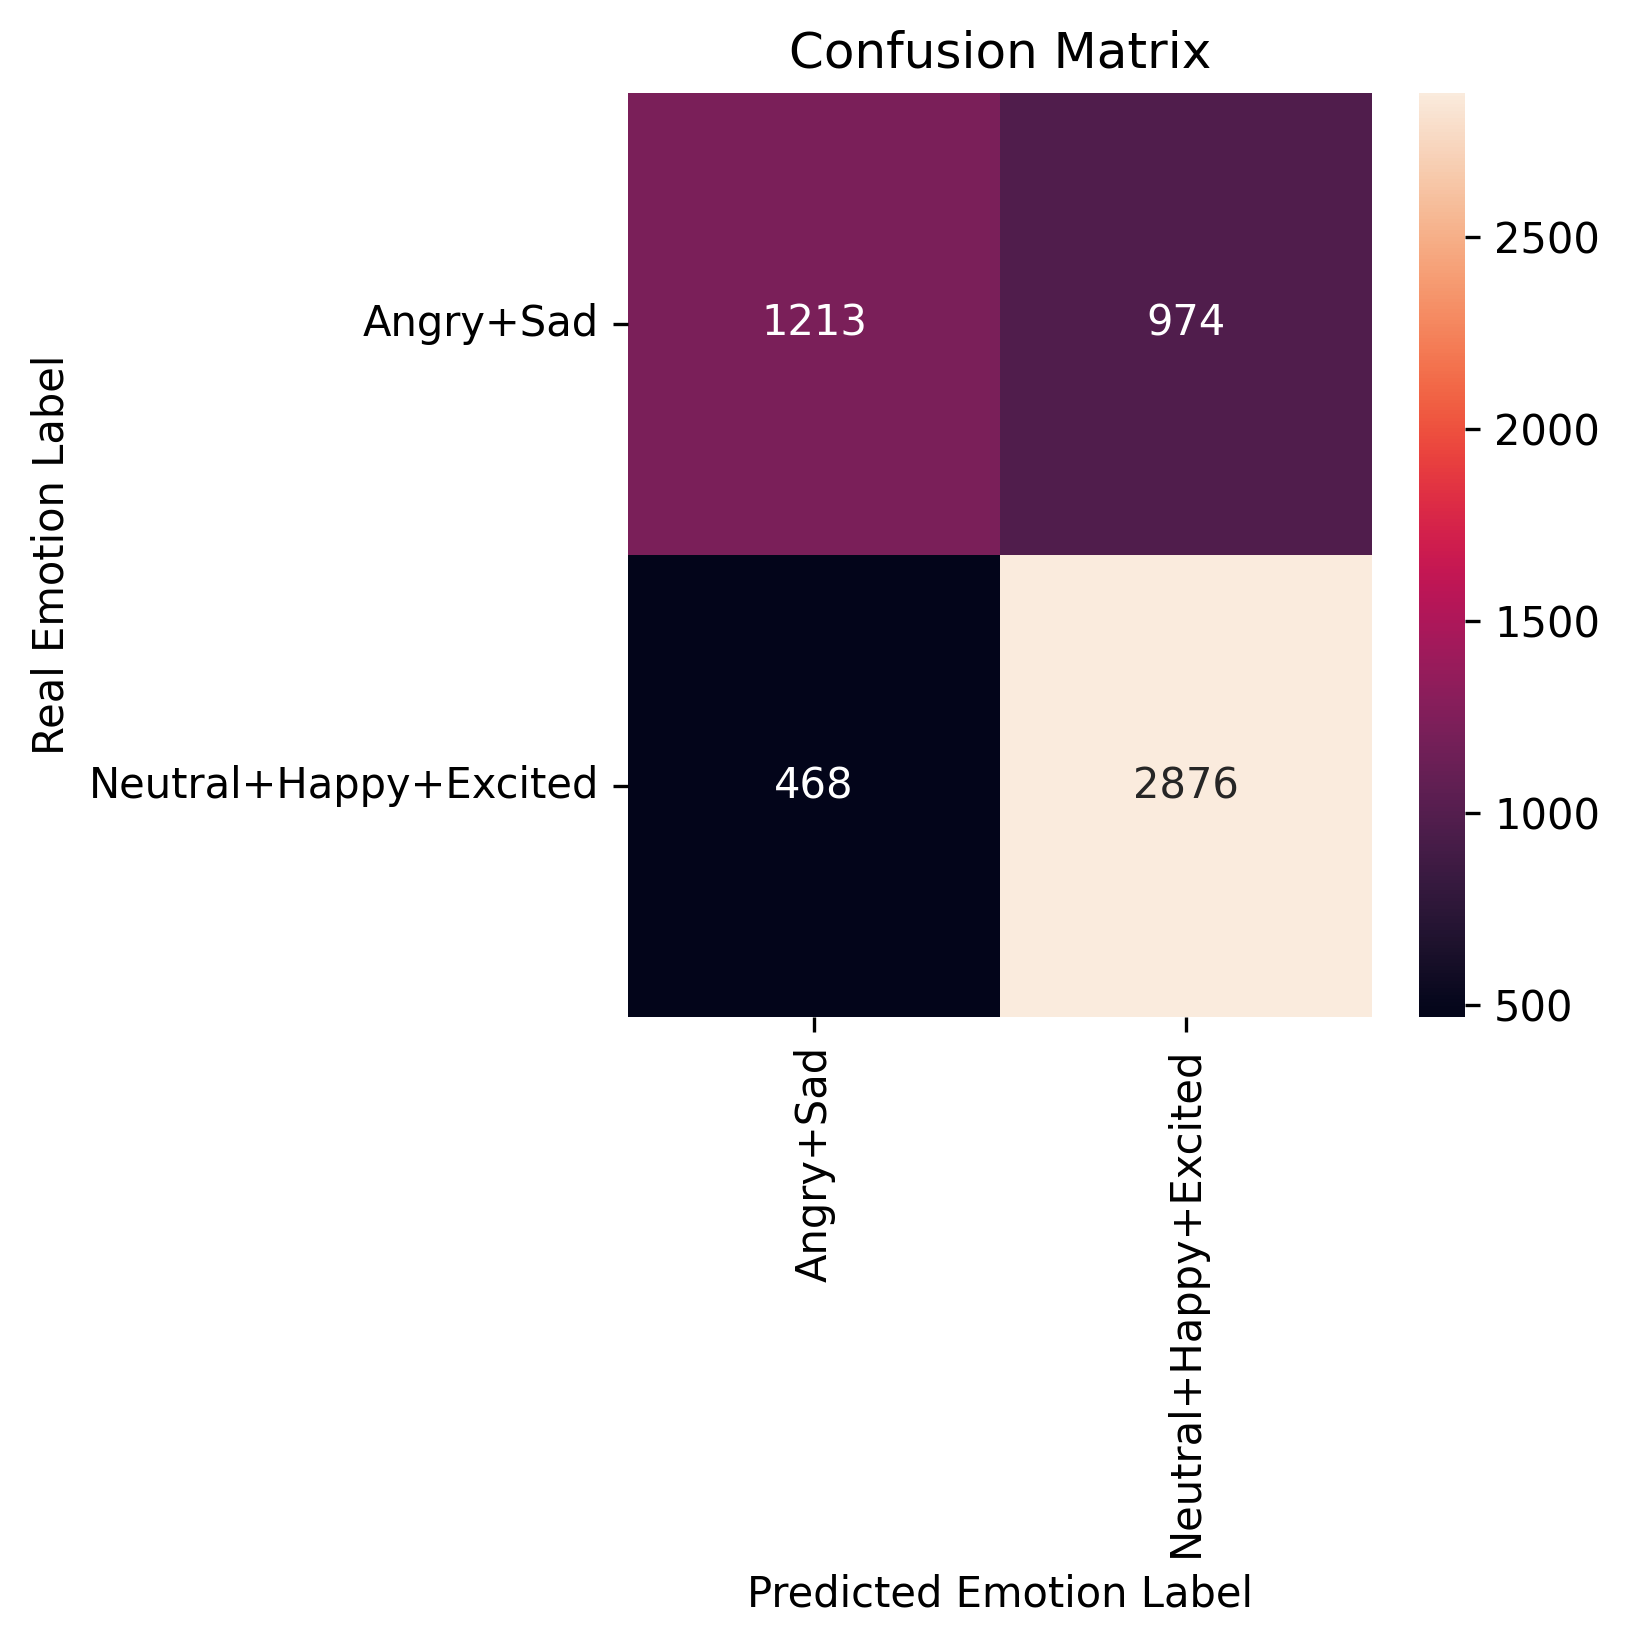

In [4]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)
df = df.sort_values(['Emotion_Id', 'Gender'], ascending = (True, True))
df = df.set_index('File')
df = df[df['Emotion'].isin({'angry', 'neutral', 'happy', 'excited', 'sad'})]
df.loc[df['Emotion_Id'] == 2, 'Emotion_Id'] = 0
df.loc[df['Emotion_Id'] == 5, 'Emotion_Id'] = 1
df.loc[df['Emotion_Id'] == 3, 'Emotion_Id'] = 1

print(f"Number of Audio Files: {df.shape[0]}")
df.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']})

def get_new_model():
    return RandomForest(n_estimators=512, n_jobs=-1, random_state=1)
results = categorical_cross_validation(get_new_model, "Angry+Sad, Neutral+Happy+Excited", results)

Angry, Happy+Excited, Sad

Number of Audio Files: 3823


,,Emotion
,,count
Emotion,Emotion_Id,
angry,0,1103
excited,1,1041
happy,1,595
sad,2,1084


Accuracy for fold 0: 72.68%
Accuracy for fold 1: 73.59%
Accuracy for fold 2: 70.98%
Accuracy for fold 3: 69.24%
Accuracy for fold 4: 73.3%

Metric             Value
-----------------  -----------
Accuracy           71.96+-1.63
F1 score macro     72.22
Precision          72.81
Recall             71.95
Matthews corrcoef  0.569


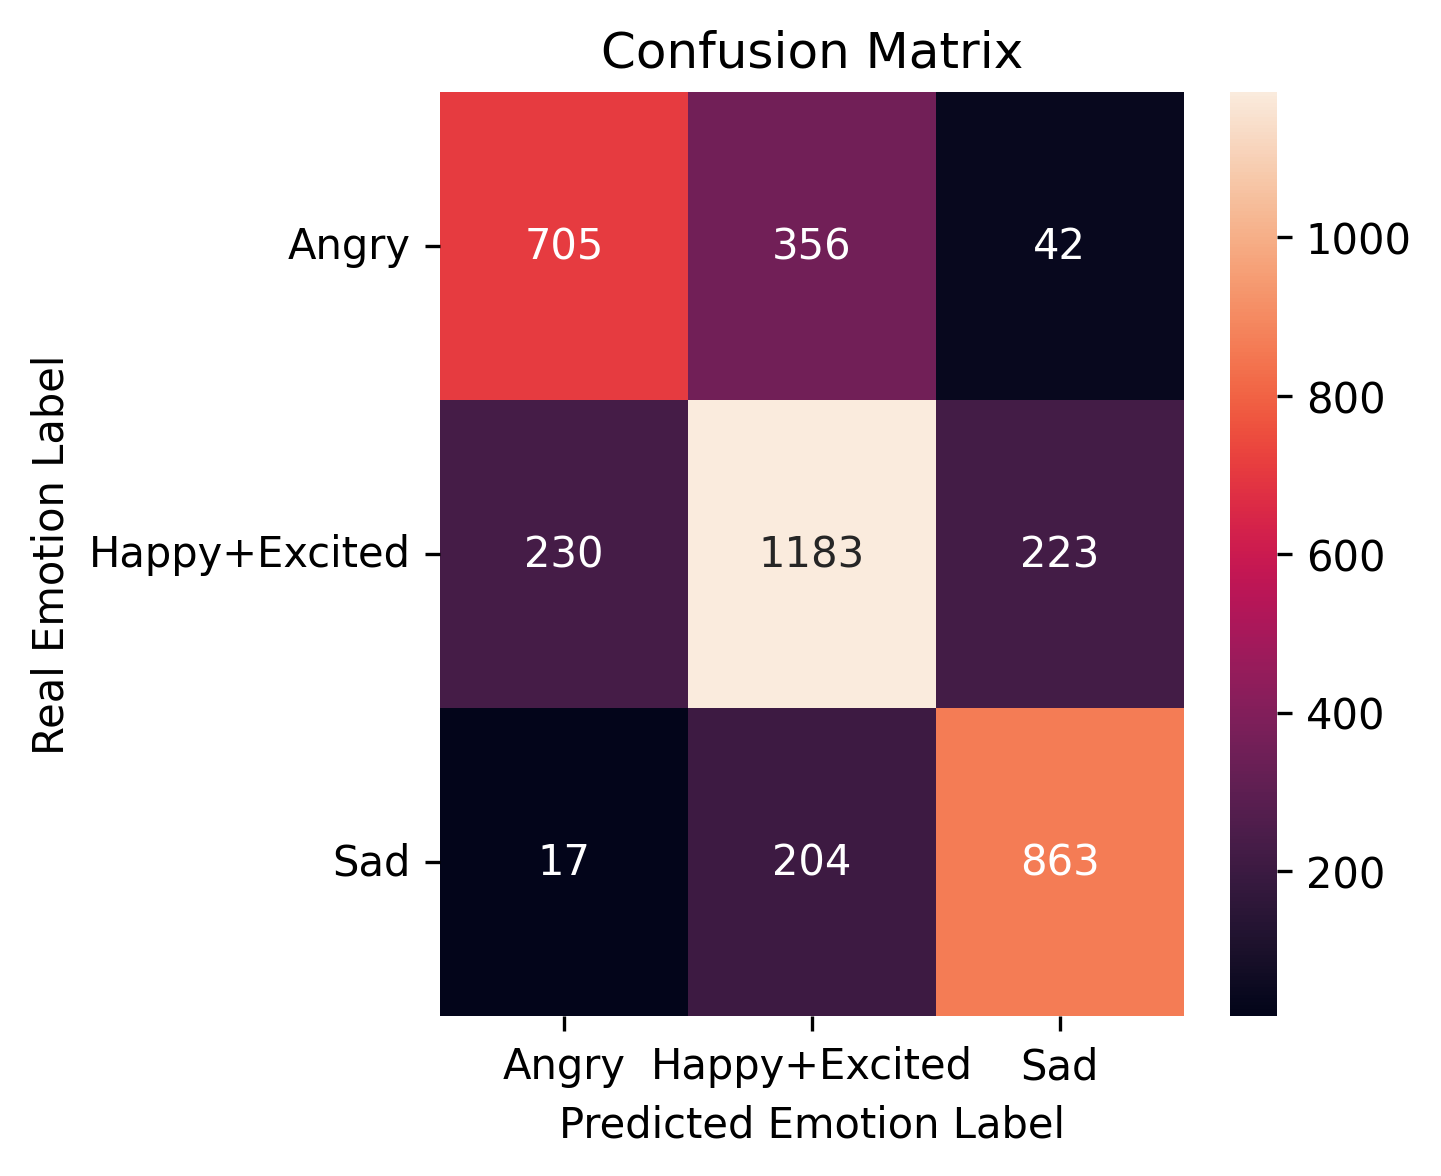

In [5]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)
df = df.sort_values(['Emotion_Id', 'Gender'], ascending = (True, True))
df = df.set_index('File')
df = df[df['Emotion'].isin({'angry',  'happy', 'excited', 'sad'})]
df.loc[df['Emotion_Id'] == 5, 'Emotion_Id'] = 1

print(f"Number of Audio Files: {df.shape[0]}")
df.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']})

def get_new_model():
    return RandomForest(n_estimators=512, n_jobs=-1, random_state=1)
results = categorical_cross_validation(get_new_model, "Angry, Happy+Excited, Sad", results)

Angry, Happy+Excited, Neutral

Number of Audio Files: 4447


,,Emotion
,,count
Emotion,Emotion_Id,
angry,0,1103
excited,1,1041
happy,1,595
neutral,2,1708


Accuracy for fold 0: 64.38%
Accuracy for fold 1: 64.61%
Accuracy for fold 2: 63.44%
Accuracy for fold 3: 65.02%
Accuracy for fold 4: 68.05%

Metric             Value
-----------------  ----------
Accuracy           65.1+-1.56
F1 score macro     64.77
Precision          66.03
Recall             64.52
Matthews corrcoef  0.467


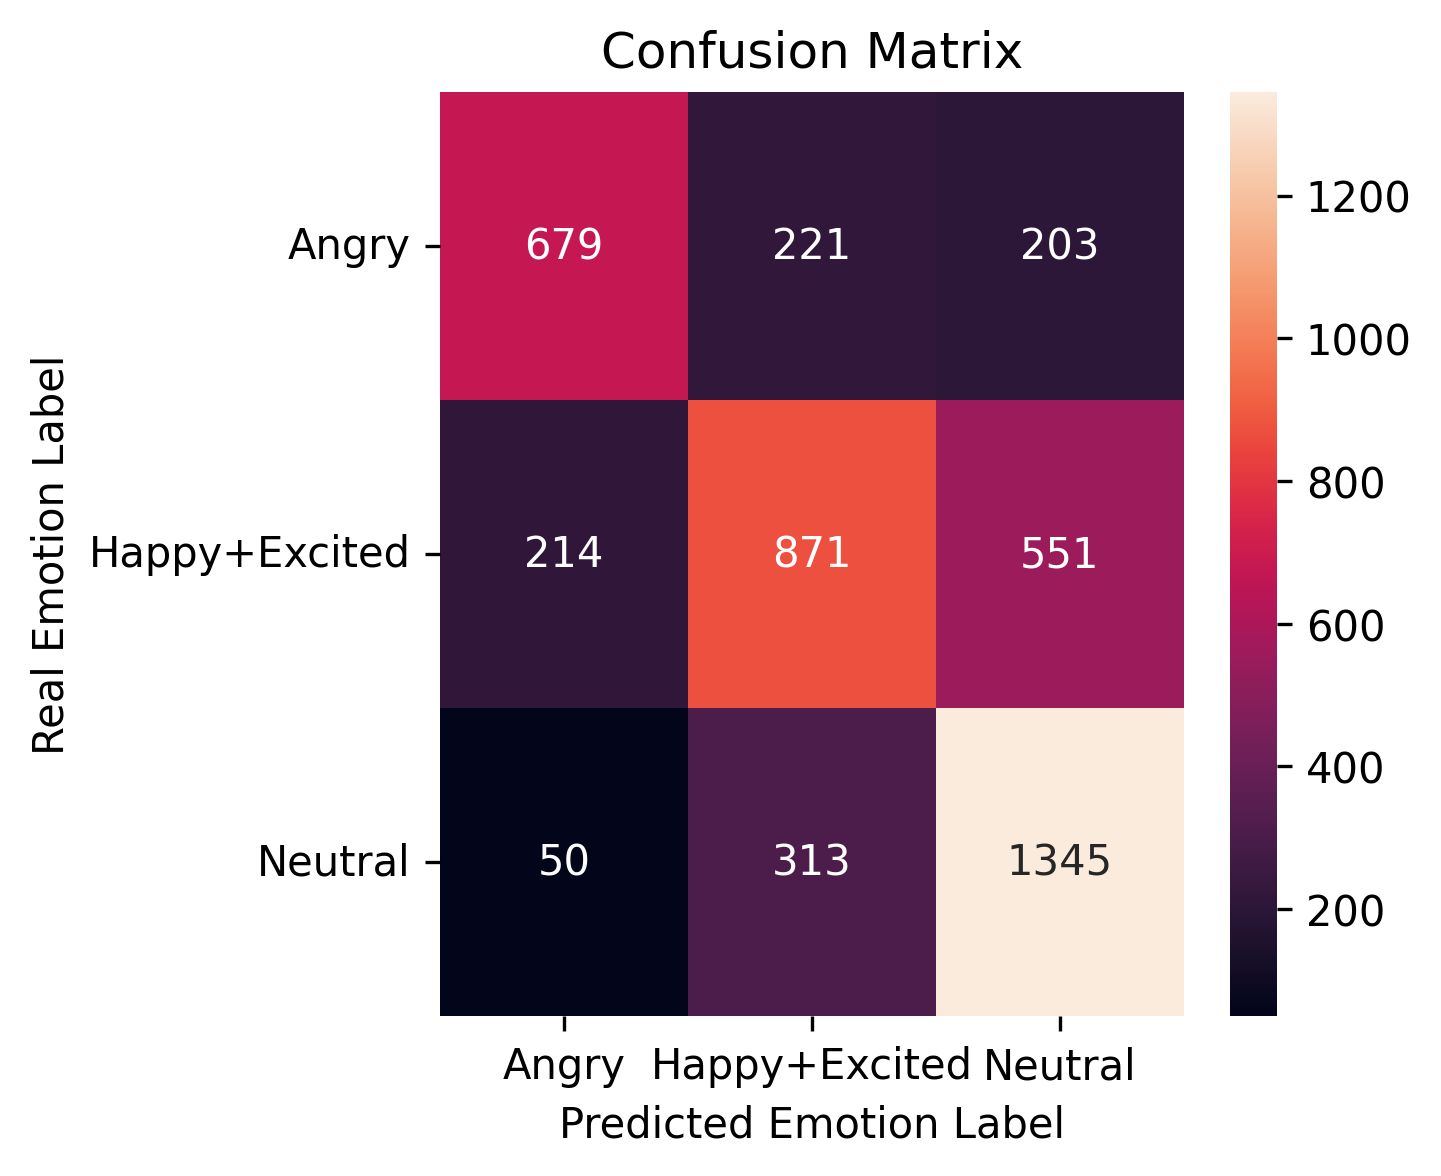

In [6]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)
df = df.sort_values(['Emotion_Id', 'Gender'], ascending = (True, True))
df = df.set_index('File')
df = df[df['Emotion'].isin({'angry', 'neutral', 'happy', 'excited'})]
df.loc[df['Emotion_Id'] == 3, 'Emotion_Id'] = 2
df.loc[df['Emotion_Id'] == 5, 'Emotion_Id'] = 1

print(f"Number of Audio Files: {df.shape[0]}")
df.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']})

def get_new_model():
    return RandomForest(n_estimators=512, n_jobs=-1, random_state=1)
results = categorical_cross_validation(get_new_model, "Angry, Happy+Excited, Neutral", results)

Sad, Happy+Excited, Neutral

Number of Audio Files: 4428


,,Emotion
,,count
Emotion,Emotion_Id,
excited,1,1041
happy,1,595
neutral,2,1708
sad,0,1084


Accuracy for fold 0: 63.32%
Accuracy for fold 1: 62.42%
Accuracy for fold 2: 68.51%
Accuracy for fold 3: 63.62%
Accuracy for fold 4: 64.07%

Metric             Value
-----------------  -----------
Accuracy           64.39+-2.13
F1 score macro     64.39
Precision          64.91
Recall             64.17
Matthews corrcoef  0.456


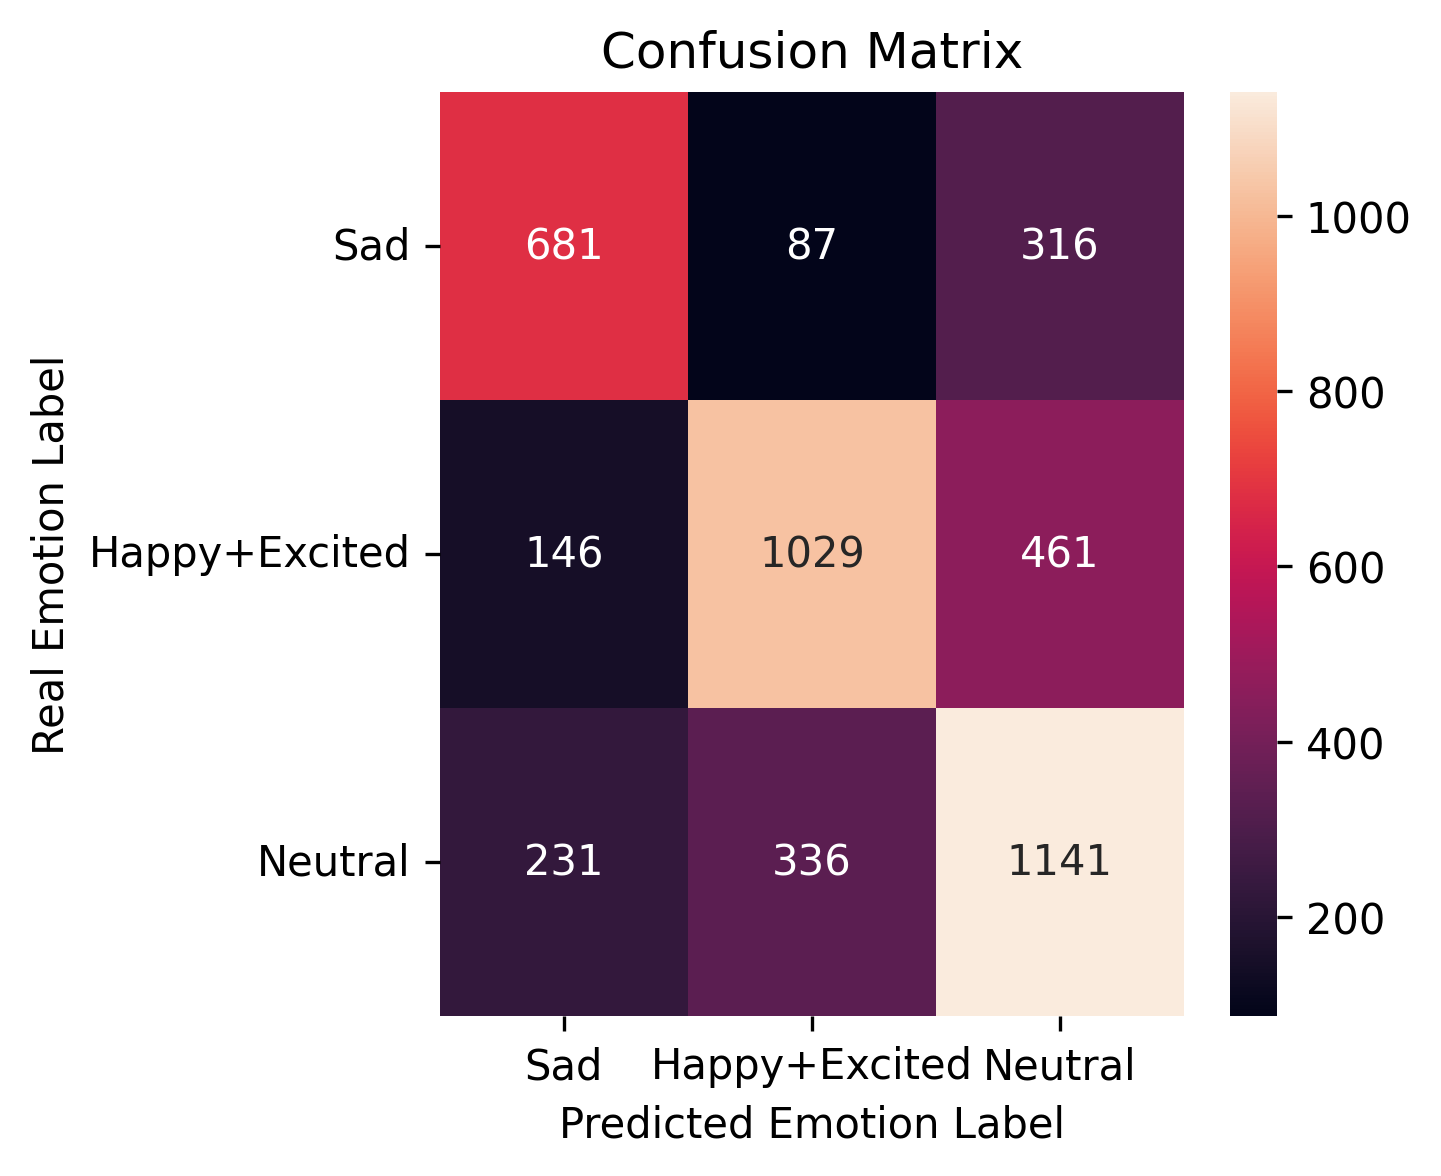

In [7]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)
df = df.sort_values(['Emotion_Id', 'Gender'], ascending = (True, True))
df = df.set_index('File')
df = df[df['Emotion'].isin({'sad', 'neutral', 'happy', 'excited'})]
df.loc[df['Emotion_Id'] == 2, 'Emotion_Id'] = 0
df.loc[df['Emotion_Id'] == 5, 'Emotion_Id'] = 1
df.loc[df['Emotion_Id'] == 3, 'Emotion_Id'] = 2

print(f"Number of Audio Files: {df.shape[0]}")
df.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']})

def get_new_model():
    return RandomForest(n_estimators=512, n_jobs=-1, random_state=1)
results = categorical_cross_validation(get_new_model, "Sad, Happy+Excited, Neutral", results)

Angry, Sad, Neutral

Number of Audio Files: 3895


,,Emotion
,,count
Emotion,Emotion_Id,
angry,0,1103
neutral,1,1708
sad,2,1084


Accuracy for fold 0: 72.53%
Accuracy for fold 1: 73.94%
Accuracy for fold 2: 73.17%
Accuracy for fold 3: 76.12%
Accuracy for fold 4: 73.3%

Metric             Value
-----------------  -----------
Accuracy           73.81+-1.24
F1 score macro     73.87
Precision          75.81
Recall             72.7
Matthews corrcoef  0.594


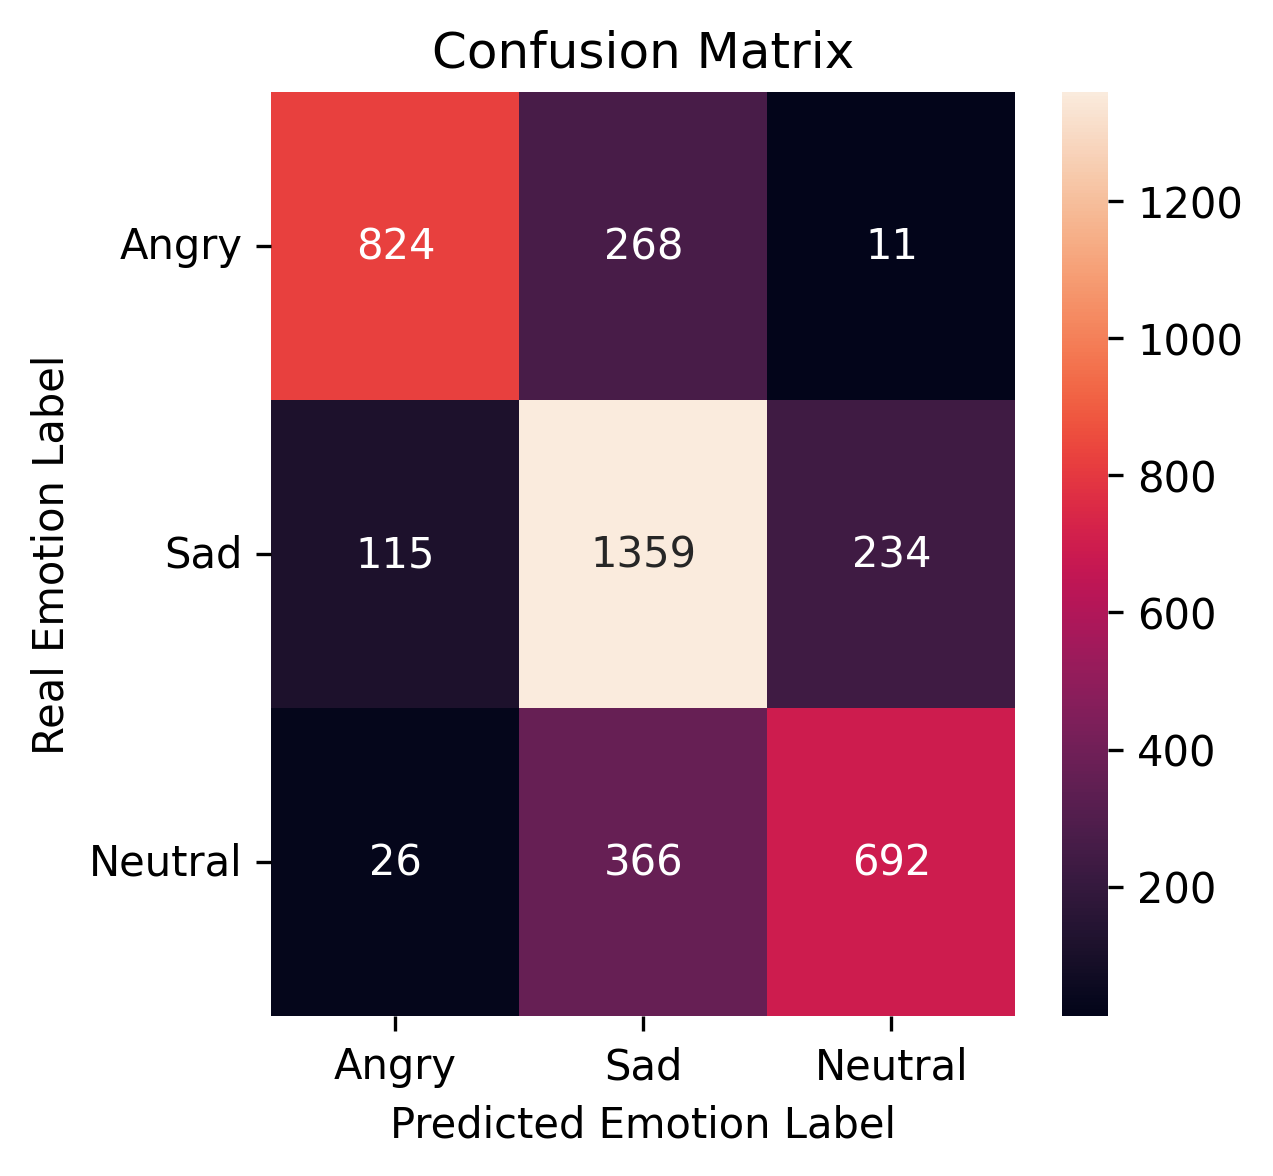

In [8]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)
df = df.sort_values(['Emotion_Id', 'Gender'], ascending = (True, True))
df = df.set_index('File')
df = df[df['Emotion'].isin({'angry', 'neutral', 'sad'})]
df.loc[df['Emotion_Id'] == 3, 'Emotion_Id'] = 1

print(f"Number of Audio Files: {df.shape[0]}")
df.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']})

def get_new_model():
    return RandomForest(n_estimators=512, n_jobs=-1, random_state=1)
results = categorical_cross_validation(get_new_model, "Angry, Sad, Neutral", results)

Angry+Sad, Happy+Excited

Number of Audio Files: 3823


,,Emotion
,,count
Emotion,Emotion_Id,
angry,0,1103
excited,1,1041
happy,1,595
sad,0,1084


Accuracy for fold 0: 76.21%
Accuracy for fold 1: 75.95%
Accuracy for fold 2: 74.25%
Accuracy for fold 3: 74.48%
Accuracy for fold 4: 75.26%

Metric             Value
-----------------  -----------
Accuracy           75.23+-0.77
F1 score macro     74.22
Precision          75.0
Recall             73.91
Matthews corrcoef  0.489


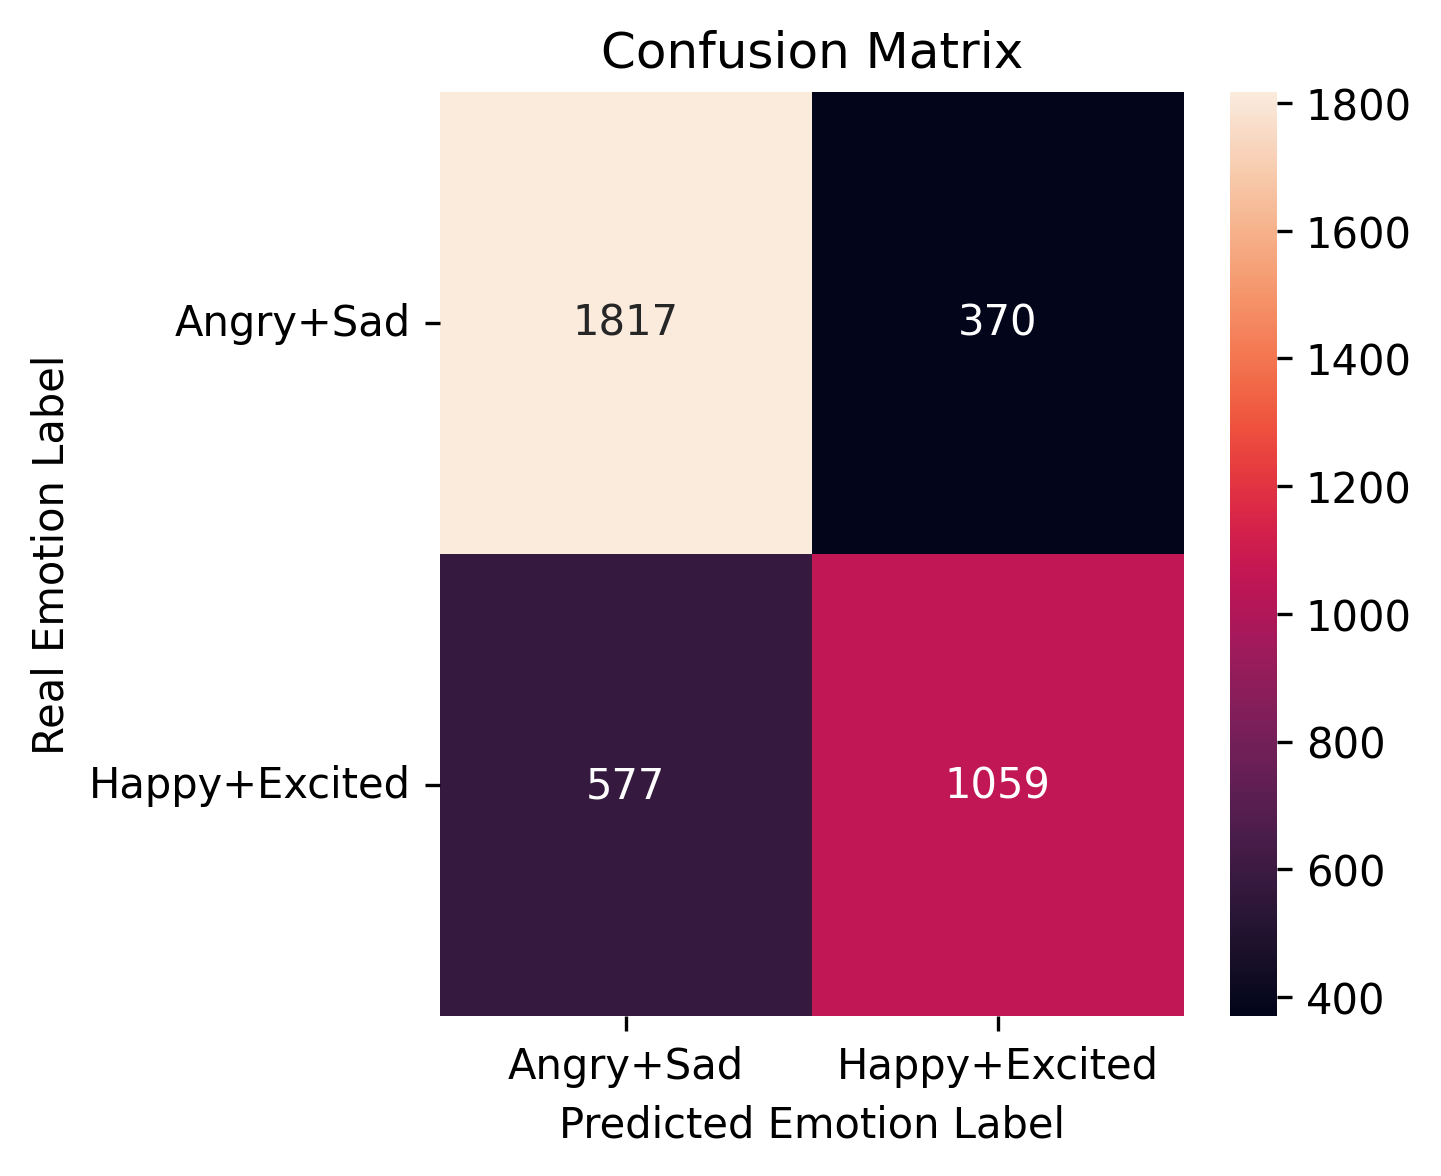

In [9]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)
df = df.sort_values(['Emotion_Id', 'Gender'], ascending = (True, True))
df = df.set_index('File')
df = df[df['Emotion'].isin({'angry', 'sad', 'happy', 'excited'})]
df.loc[df['Emotion_Id'] == 2, 'Emotion_Id'] = 0
df.loc[df['Emotion_Id'] == 5, 'Emotion_Id'] = 1

print(f"Number of Audio Files: {df.shape[0]}")
df.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']})

def get_new_model():
    return RandomForest(n_estimators=512, n_jobs=-1, random_state=1)
results = categorical_cross_validation(get_new_model, "Angry+Sad, Happy+Excited", results)

Angry+Sad, Happy+Excited, Neutral

Number of Audio Files: 5531


,,Emotion
,,count
Emotion,Emotion_Id,
angry,0,1103
excited,1,1041
happy,1,595
neutral,2,1708
sad,0,1084


Accuracy for fold 0: 59.98%
Accuracy for fold 1: 63.11%
Accuracy for fold 2: 59.86%
Accuracy for fold 3: 61.48%
Accuracy for fold 4: 60.94%

Metric             Value
-----------------  -----------
Accuracy           61.07+-1.18
F1 score macro     60.16
Precision          60.59
Recall             60.18
Matthews corrcoef  0.41


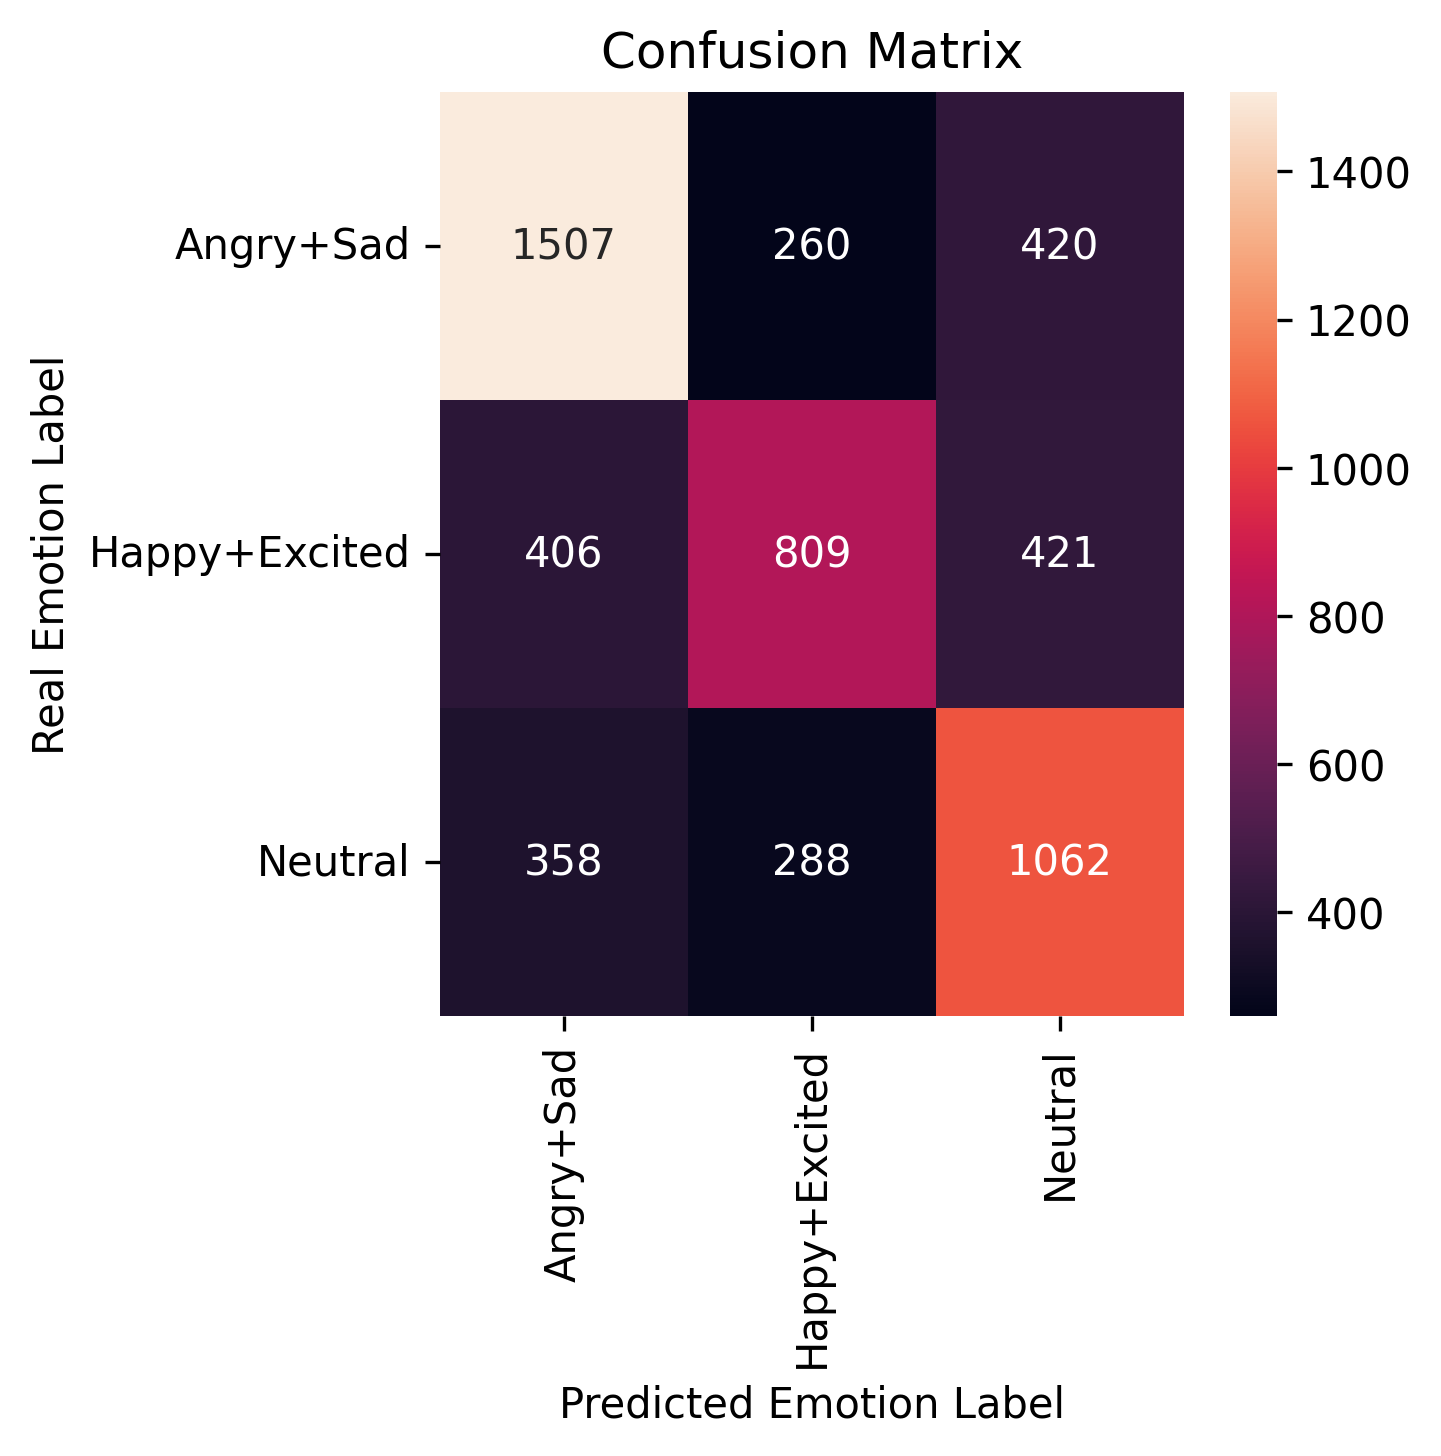

In [10]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)
df = df.sort_values(['Emotion_Id', 'Gender'], ascending = (True, True))
df = df.set_index('File')
df = df[df['Emotion'].isin({'angry', 'sad', 'neutral', 'happy', 'excited'})]
df.loc[df['Emotion_Id'] == 2, 'Emotion_Id'] = 0
df.loc[df['Emotion_Id'] == 3, 'Emotion_Id'] = 2
df.loc[df['Emotion_Id'] == 5, 'Emotion_Id'] = 1

print(f"Number of Audio Files: {df.shape[0]}")
df.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']})

def get_new_model():
    return RandomForest(n_estimators=512, n_jobs=-1, random_state=1)
results = categorical_cross_validation(get_new_model, "Angry+Sad, Happy+Excited, Neutral", results)

Angry, Sad

Number of Audio Files: 2187


,,Emotion
,,count
Emotion,Emotion_Id,
angry,0,1103
sad,1,1084


Accuracy for fold 0: 91.32%
Accuracy for fold 1: 91.78%
Accuracy for fold 2: 93.59%
Accuracy for fold 3: 93.14%
Accuracy for fold 4: 90.39%

Metric             Value
-----------------  -----------
Accuracy           92.04+-1.18
F1 score macro     92.04
Precision          92.05
Recall             92.04
Matthews corrcoef  0.841


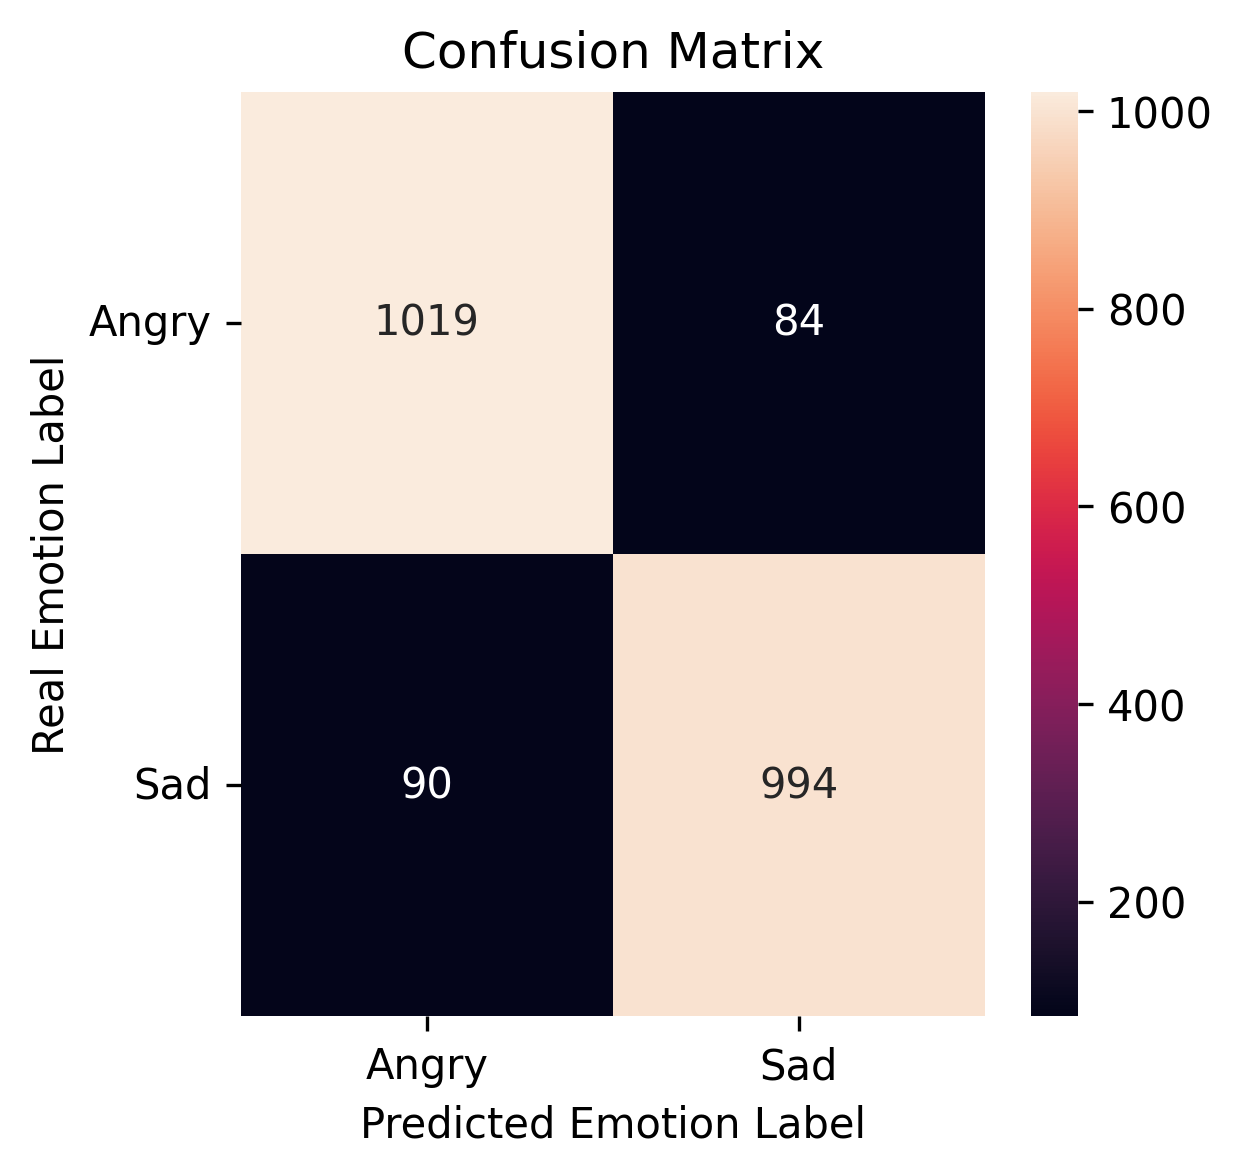

In [11]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)
df = df.sort_values(['Emotion_Id', 'Gender'], ascending = (True, True))
df = df.set_index('File')
df = df[df['Emotion'].isin({'angry', 'sad'})]
df.loc[df['Emotion_Id'] == 2, 'Emotion_Id'] = 1

print(f"Number of Audio Files: {df.shape[0]}")
df.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']})

def get_new_model():
    return RandomForest(n_estimators=512, n_jobs=-1, random_state=1)
results = categorical_cross_validation(get_new_model, "Angry, Sad", results)

Angry, Neutral

Number of Audio Files: 2811


,,Emotion
,,count
Emotion,Emotion_Id,
angry,0,1103
neutral,1,1708


Accuracy for fold 0: 83.48%
Accuracy for fold 1: 85.77%
Accuracy for fold 2: 85.59%
Accuracy for fold 3: 87.01%
Accuracy for fold 4: 86.3%

Metric             Value
-----------------  -----------
Accuracy           85.63+-1.18
F1 score macro     84.42
Precision          86.18
Recall             83.5
Matthews corrcoef  0.696


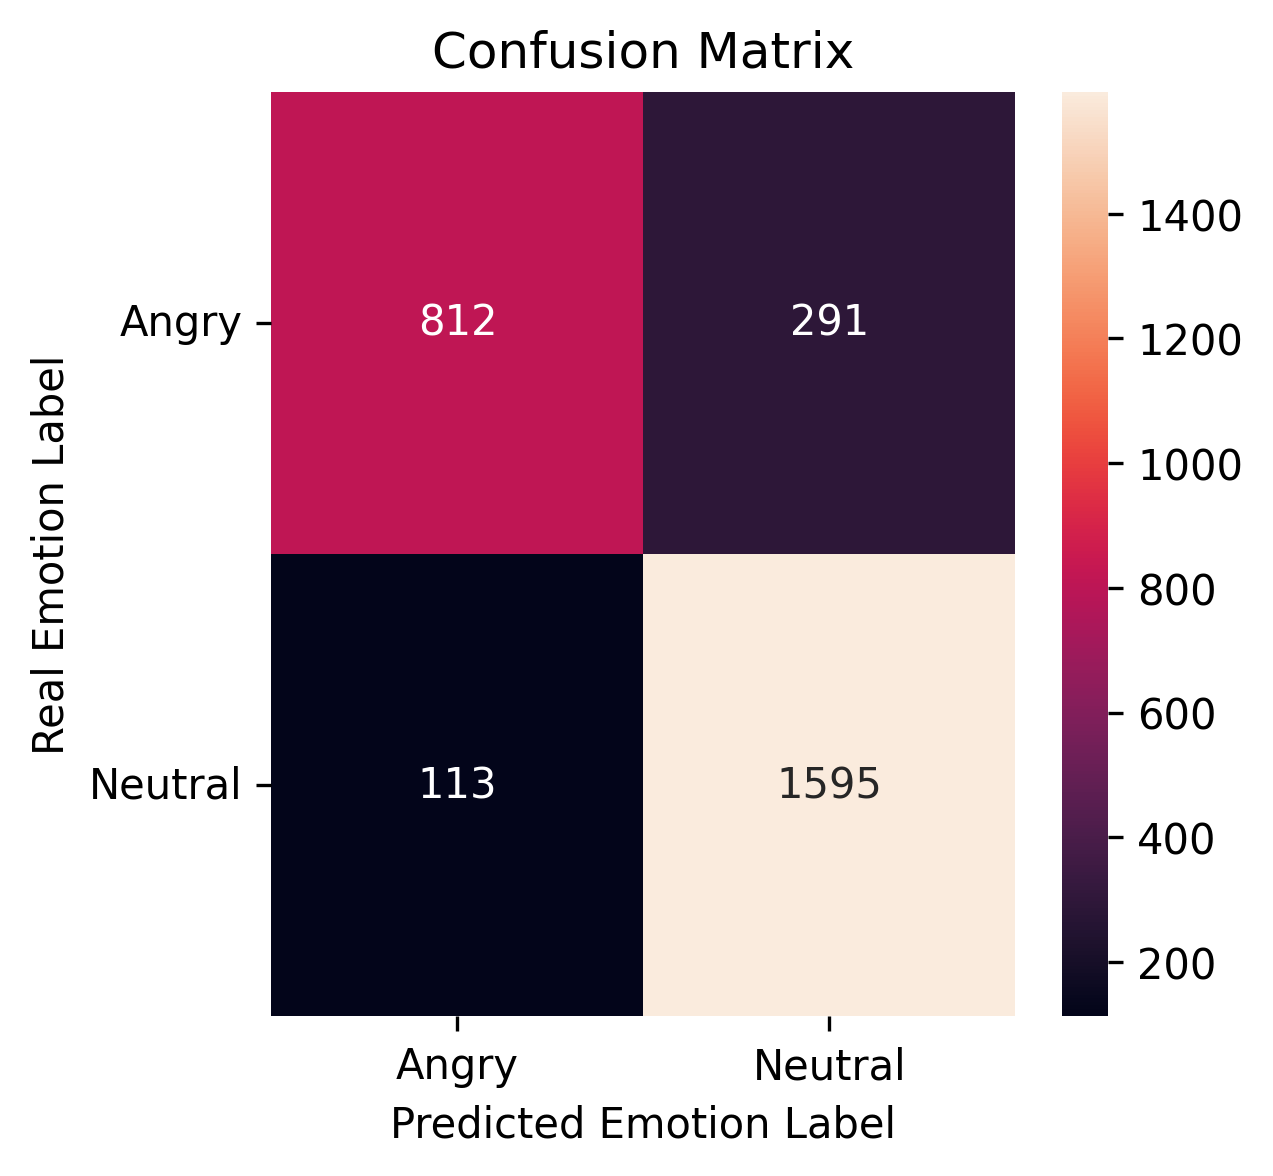

In [12]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)
df = df.sort_values(['Emotion_Id', 'Gender'], ascending = (True, True))
df = df.set_index('File')
df = df[df['Emotion'].isin({'angry', 'neutral'})]
df.loc[df['Emotion_Id'] == 3, 'Emotion_Id'] = 1

print(f"Number of Audio Files: {df.shape[0]}")
df.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']})

def get_new_model():
    return RandomForest(n_estimators=512, n_jobs=-1, random_state=1)
results = categorical_cross_validation(get_new_model, "Angry, Neutral", results)

Angry, Happy+Excited

Number of Audio Files: 2739


,,Emotion
,,count
Emotion,Emotion_Id,
angry,0,1103
excited,1,1041
happy,1,595


Accuracy for fold 0: 73.91%
Accuracy for fold 1: 77.92%
Accuracy for fold 2: 78.1%
Accuracy for fold 3: 75.18%
Accuracy for fold 4: 78.79%

Metric             Value
-----------------  -----------
Accuracy           76.78+-1.89
F1 score macro     75.32
Precision          76.17
Recall             74.88
Matthews corrcoef  0.51


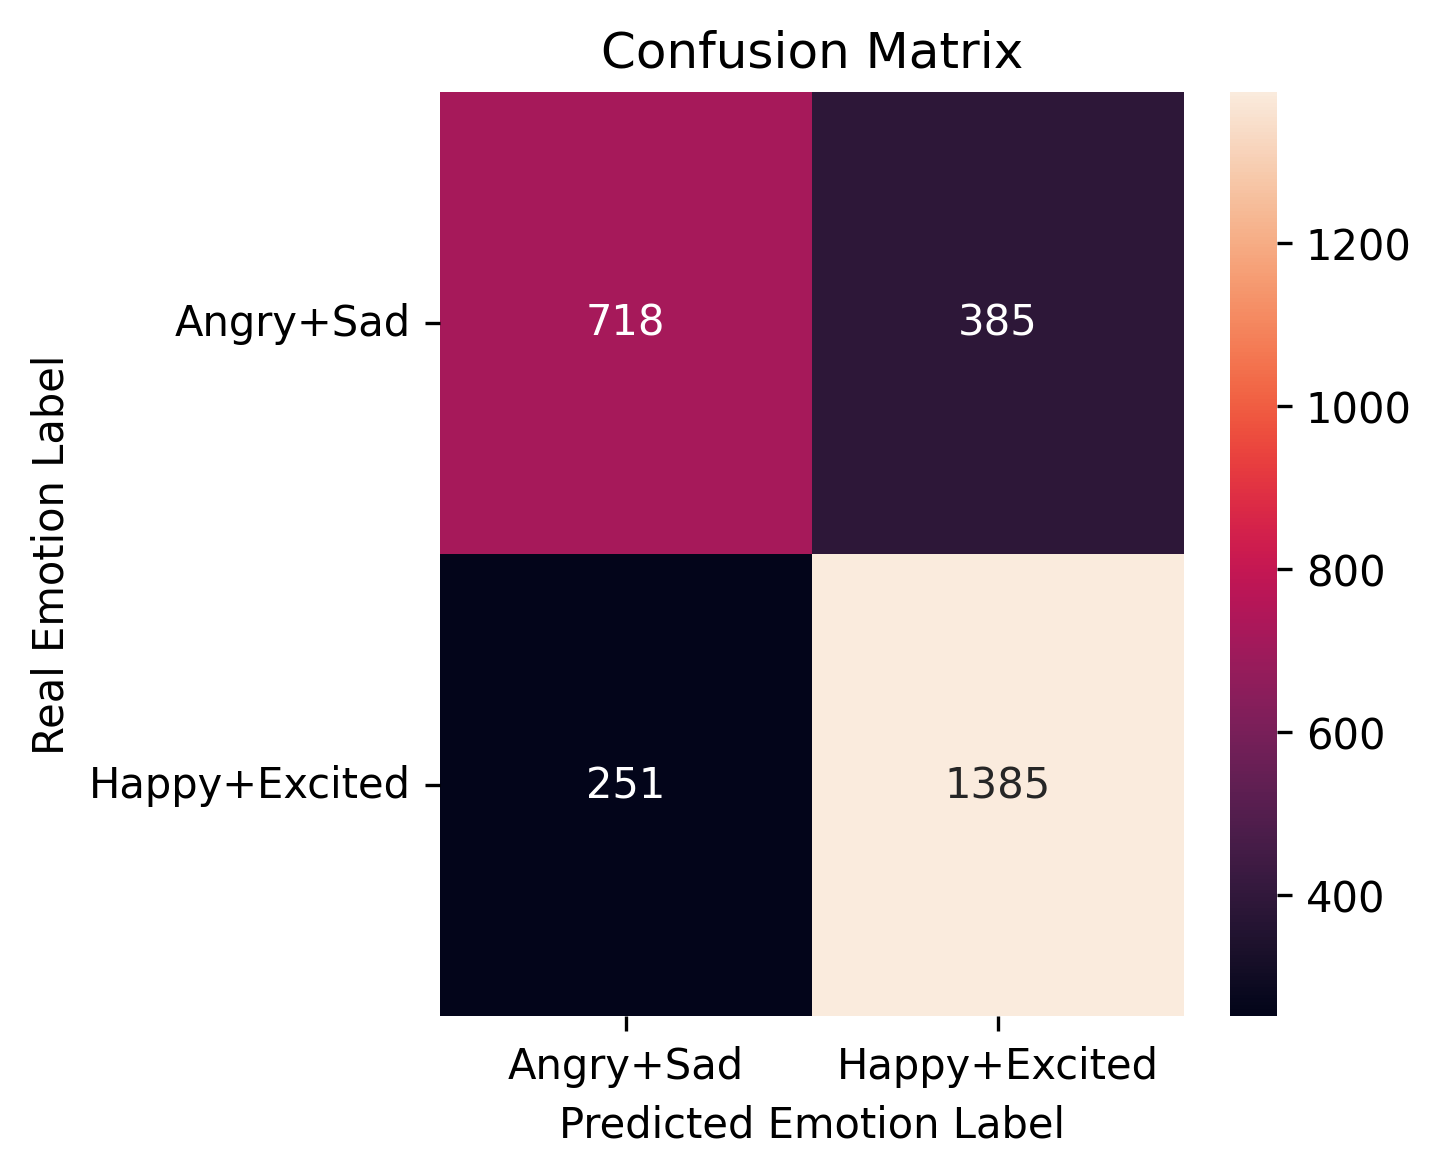

In [13]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)
df = df.sort_values(['Emotion_Id', 'Gender'], ascending = (True, True))
df = df.set_index('File')
df = df[df['Emotion'].isin({'angry', 'happy', 'excited'})]
df.loc[df['Emotion_Id'] == 5, 'Emotion_Id'] = 1

print(f"Number of Audio Files: {df.shape[0]}")
df.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']})

def get_new_model():
    return RandomForest(n_estimators=512, n_jobs=-1, random_state=1)
results = categorical_cross_validation(get_new_model, "Angry+Sad, Happy+Excited", results)

Sad, Neutral

Number of Audio Files: 2792


,,Emotion
,,count
Emotion,Emotion_Id,
neutral,1,1708
sad,0,1084


Accuracy for fold 0: 78.0%
Accuracy for fold 1: 76.57%
Accuracy for fold 2: 78.14%
Accuracy for fold 3: 78.49%
Accuracy for fold 4: 79.21%

Metric             Value
-----------------  -----------
Accuracy           78.08+-0.86
F1 score macro     76.34
Precision          77.3
Recall             75.8
Matthews corrcoef  0.531


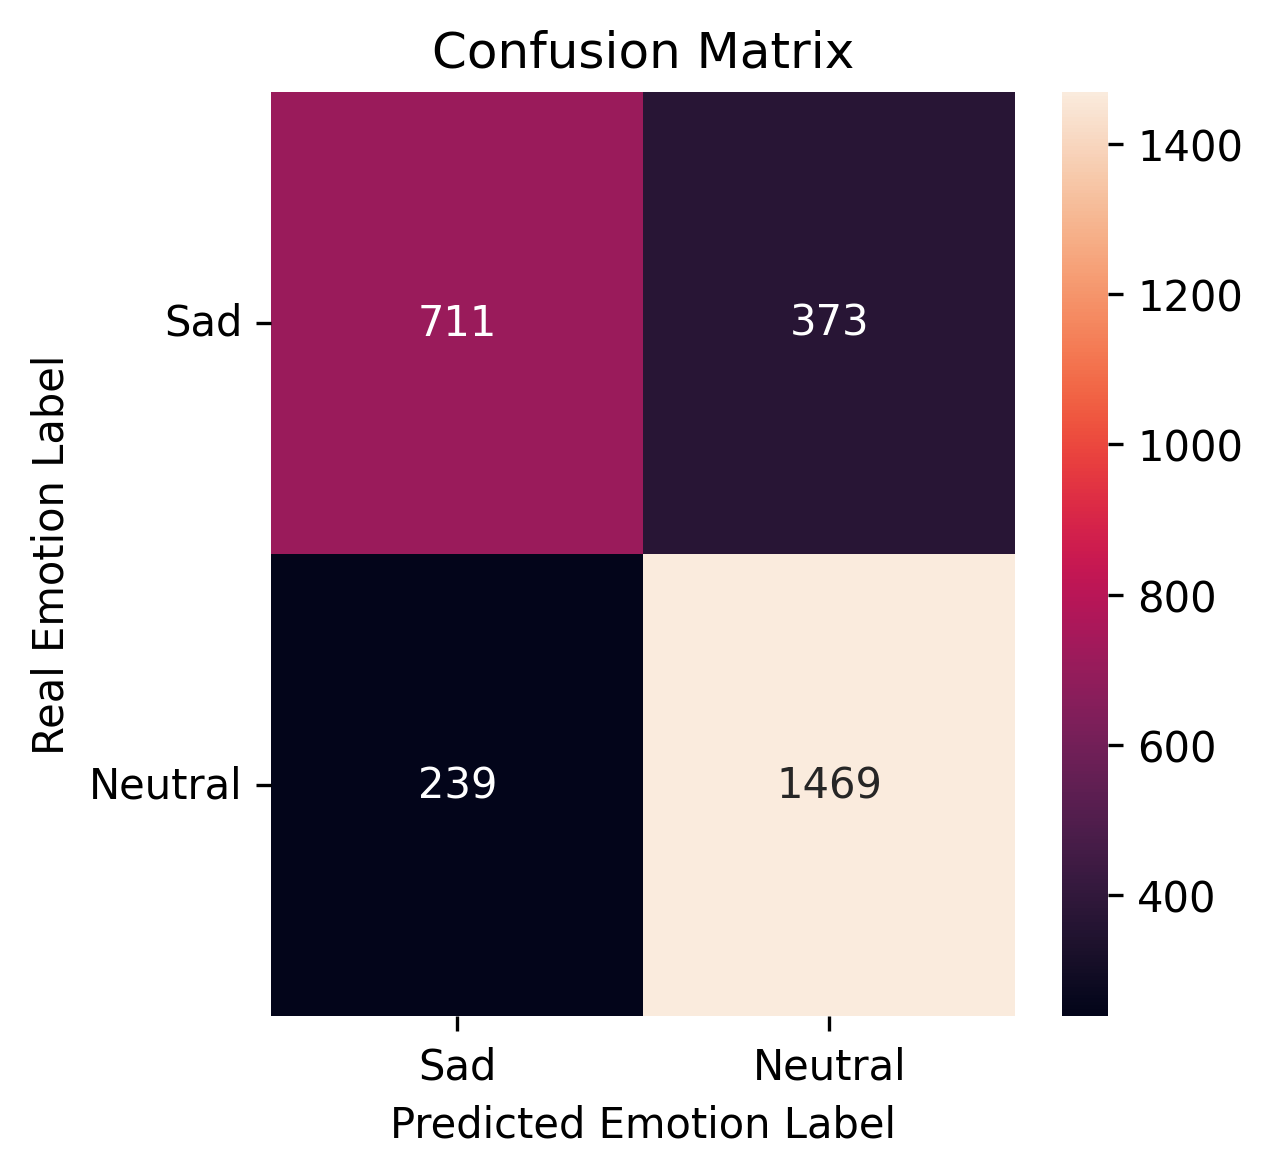

In [14]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)
df = df.sort_values(['Emotion_Id', 'Gender'], ascending = (True, True))
df = df.set_index('File')
df = df[df['Emotion'].isin({'sad', 'neutral'})]
df.loc[df['Emotion_Id'] == 2, 'Emotion_Id'] = 0
df.loc[df['Emotion_Id'] == 3, 'Emotion_Id'] = 1

print(f"Number of Audio Files: {df.shape[0]}")
df.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']})

def get_new_model():
    return RandomForest(n_estimators=512, n_jobs=-1, random_state=1)
results = categorical_cross_validation(get_new_model, "Sad, Neutral", results)

Sad, Happy+Excited

Number of Audio Files: 2720


,,Emotion
,,count
Emotion,Emotion_Id,
excited,1,1041
happy,1,595
sad,0,1084


Accuracy for fold 0: 82.72%
Accuracy for fold 1: 83.64%
Accuracy for fold 2: 86.76%
Accuracy for fold 3: 81.99%
Accuracy for fold 4: 84.56%

Metric             Value
-----------------  -----------
Accuracy           83.93+-1.66
F1 score macro     83.27
Precision          83.22
Recall             83.33
Matthews corrcoef  0.665


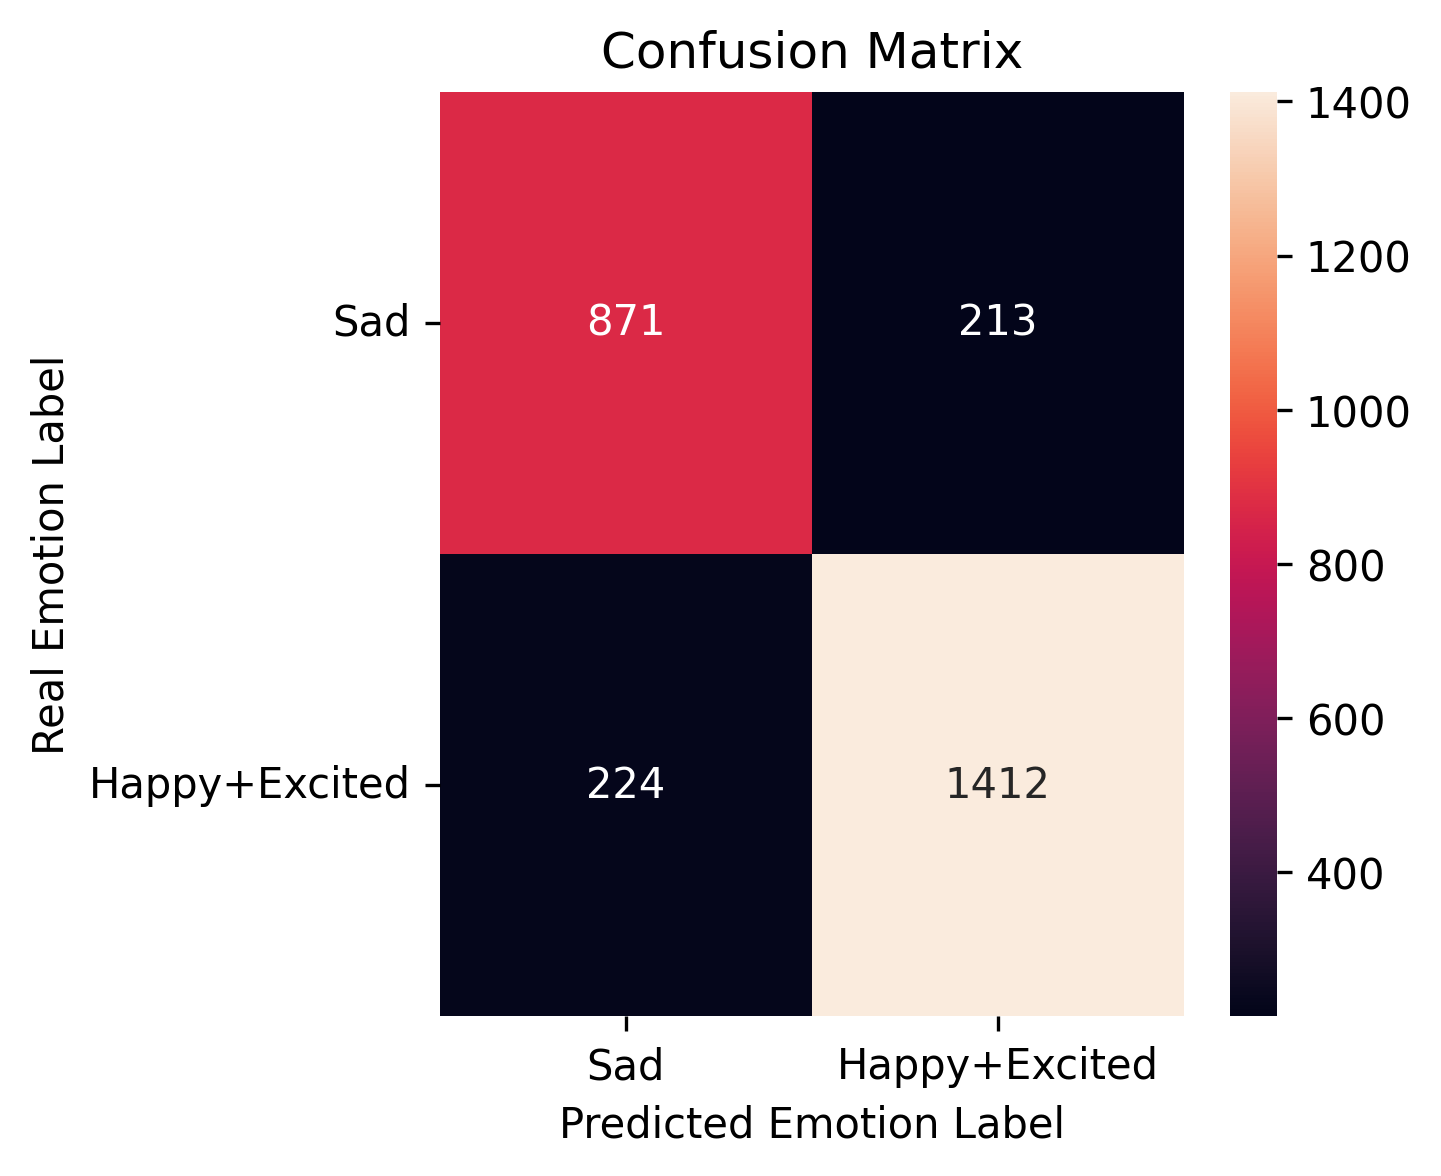

In [15]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)
df = df.sort_values(['Emotion_Id', 'Gender'], ascending = (True, True))
df = df.set_index('File')
df = df[df['Emotion'].isin({'sad', 'happy', 'excited'})]
df.loc[df['Emotion_Id'] == 2, 'Emotion_Id'] = 0
df.loc[df['Emotion_Id'] == 5, 'Emotion_Id'] = 1

print(f"Number of Audio Files: {df.shape[0]}")
df.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']})

def get_new_model():
    return RandomForest(n_estimators=512, n_jobs=-1, random_state=1)
results = categorical_cross_validation(get_new_model, "Sad, Happy+Excited", results)

Neutral, Happy+Excited

Number of Audio Files: 3344


,,Emotion
,,count
Emotion,Emotion_Id,
excited,1,1041
happy,1,595
neutral,0,1708


Accuracy for fold 0: 72.05%
Accuracy for fold 1: 72.8%
Accuracy for fold 2: 73.39%
Accuracy for fold 3: 71.3%
Accuracy for fold 4: 73.05%

Metric             Value
-----------------  -----------
Accuracy           72.52+-0.75
F1 score macro     72.32
Precision          72.85
Recall             72.37
Matthews corrcoef  0.452


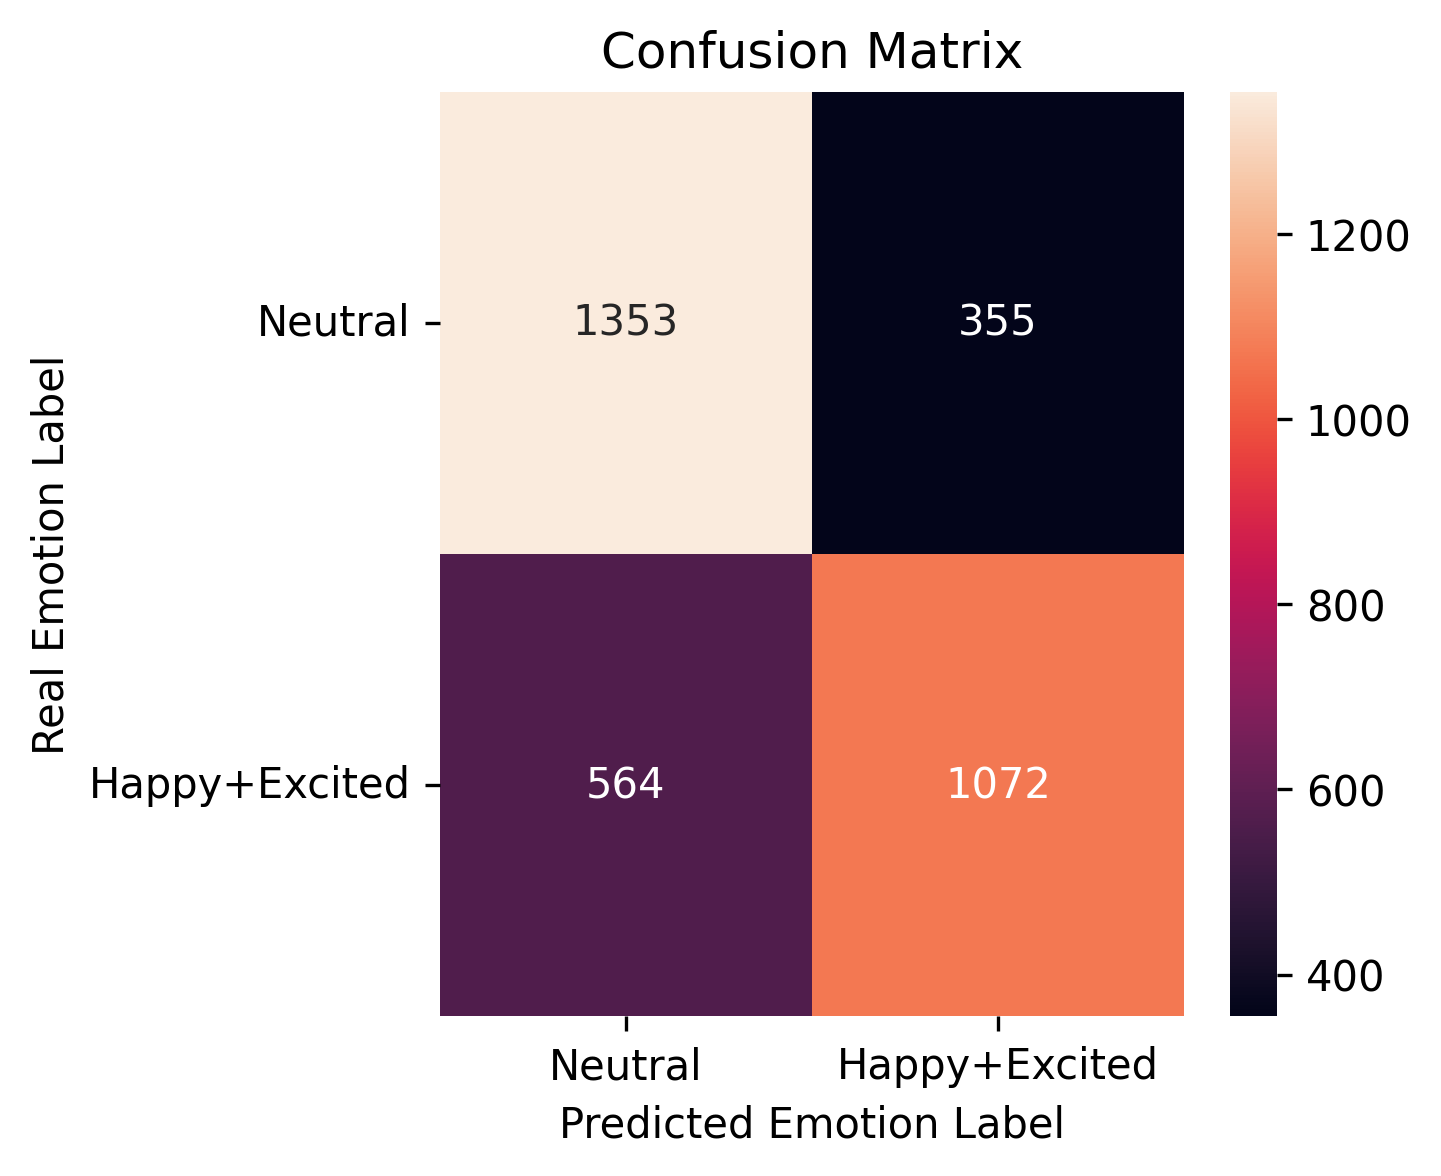

In [16]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)
df = df.sort_values(['Emotion_Id', 'Gender'], ascending = (True, True))
df = df.set_index('File')
df = df[df['Emotion'].isin({'neutral', 'happy', 'excited'})]
df.loc[df['Emotion_Id'] == 3, 'Emotion_Id'] = 0
df.loc[df['Emotion_Id'] == 5, 'Emotion_Id'] = 1

print(f"Number of Audio Files: {df.shape[0]}")
df.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']})

def get_new_model():
    return RandomForest(n_estimators=512, n_jobs=-1, random_state=1)
results = categorical_cross_validation(get_new_model, "Neutral, Happy+Excited", results)

In [17]:
display(HTML('<a href="https://www.researchgate.net/figure/Russel-circumplex-model-of-emotion-16-The-vertical-axis-represents-the-activation_fig1_328836839"><img src="https://www.researchgate.net/profile/Rab-Nawaz-12/publication/328836839/figure/fig1/AS:702472028971012@1544493791715/Russel-circumplex-model-of-emotion-16-The-vertical-axis-represents-the-activation.ppm" alt="Russel circumplex model of emotion [16]. The vertical axis represents the activation level (Arousal) and Horizontal axis represents the pleasure level (Valence) II."/></a>'))

Arousal plane - Happy+Excited+Angry, Neutral, Sad

Number of Audio Files: 5531


,,Emotion
,,count
Emotion,Emotion_Id,
angry,0,1103
excited,0,1041
happy,0,595
neutral,1,1708
sad,2,1084


Accuracy for fold 0: 66.94%
Accuracy for fold 1: 67.45%
Accuracy for fold 2: 67.27%
Accuracy for fold 3: 70.98%
Accuracy for fold 4: 68.72%

Metric             Value
-----------------  -----------
Accuracy           68.27+-1.48
F1 score macro     65.43
Precision          65.73
Recall             65.19
Matthews corrcoef  0.485


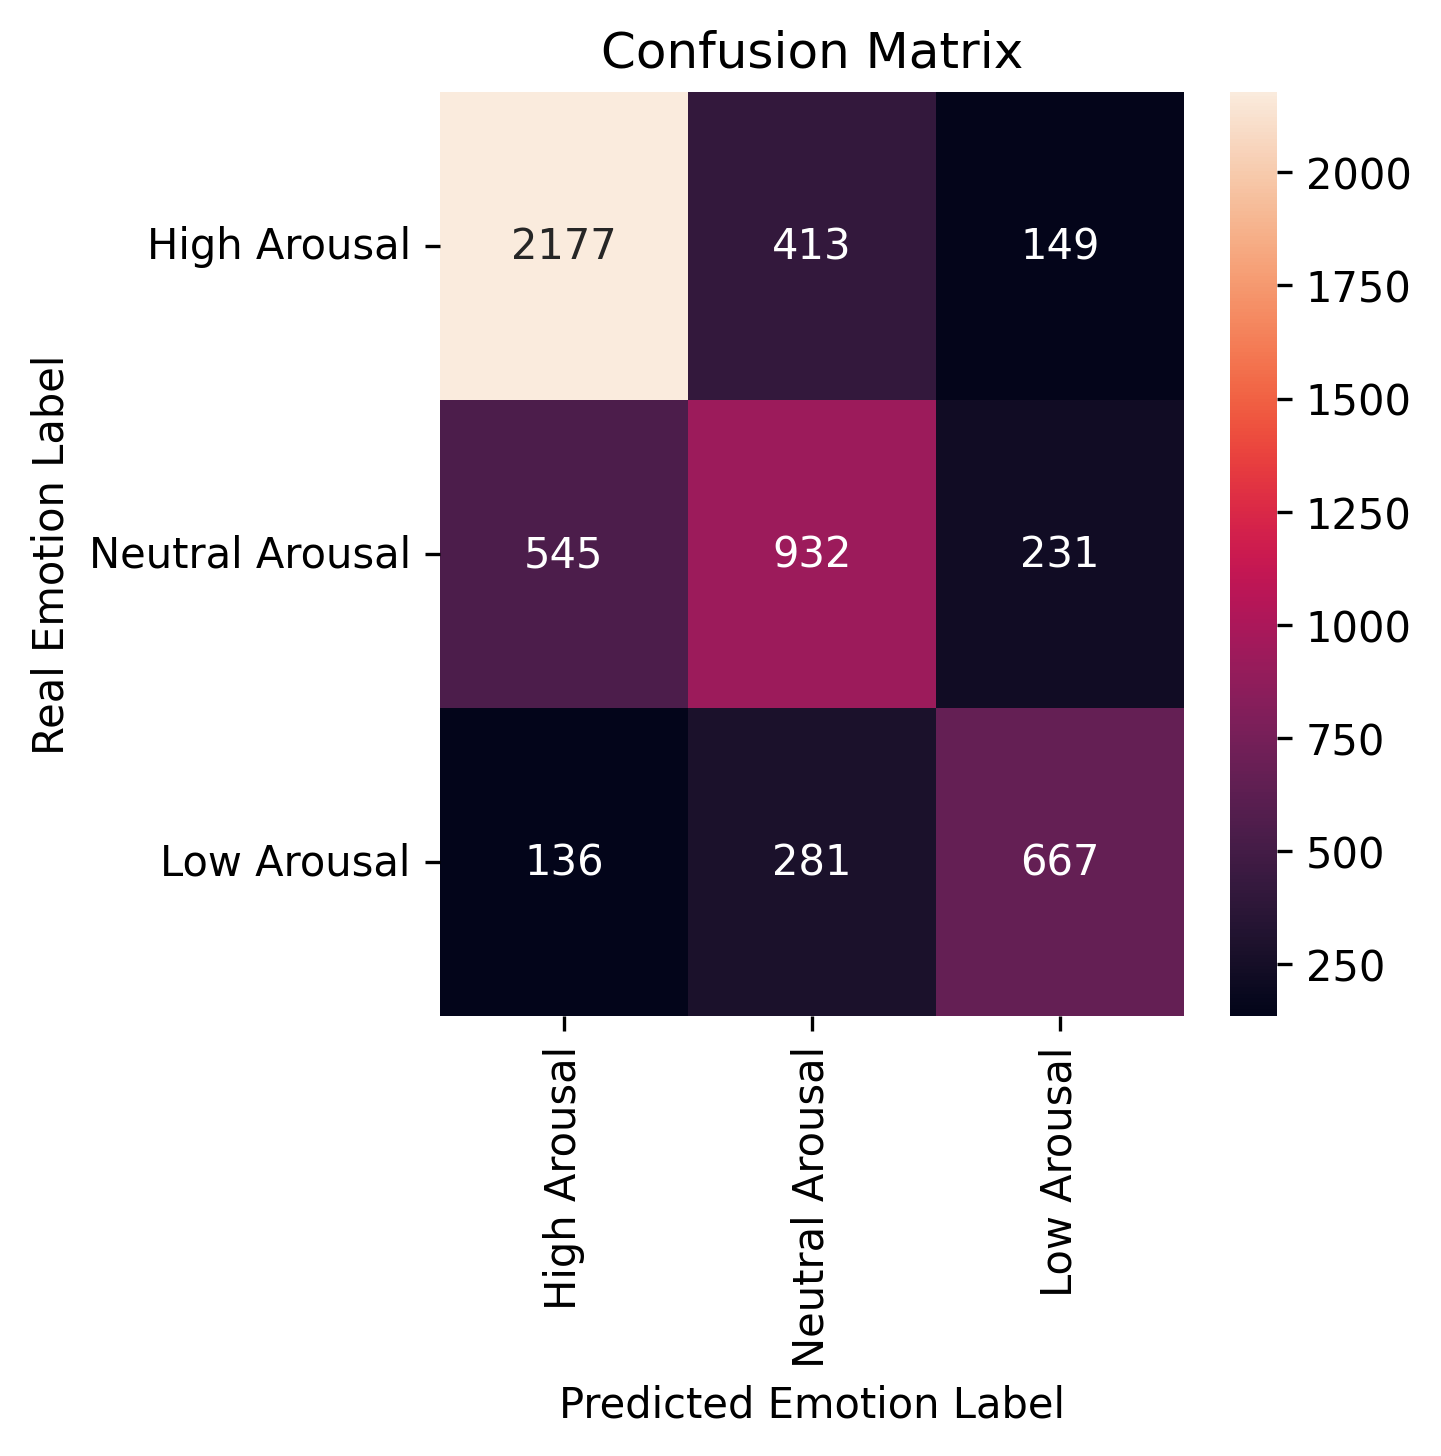

In [30]:
# Research article to corroborate this result: 10.21437/ICSLP.2002-557
df = pd.read_csv(EXTRACTED_FEATURES_FILE)
df = df.sort_values(['Emotion_Id', 'Gender'], ascending = (True, True))
df = df.set_index('File')
df = df[df['Emotion'].isin({'angry', 'sad', 'neutral', 'happy', 'excited'})]
df.loc[df['Emotion_Id'] == 1, 'Emotion_Id'] = 0
df.loc[df['Emotion_Id'] == 5, 'Emotion_Id'] = 0
df.loc[df['Emotion_Id'] == 3, 'Emotion_Id'] = 1

print(f"Number of Audio Files: {df.shape[0]}")
df.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']})

def get_new_model():
    return RandomForest(n_estimators=512, n_jobs=-1, random_state=1)
results = categorical_cross_validation(get_new_model, "High Arousal, Neutral Arousal, Low Arousal", results)

Valence Plane - Happy+Excited, Neutral, Sad+Angry

Number of Audio Files: 5531


,,Emotion
,,count
Emotion,Emotion_Id,
angry,2,1103
excited,0,1041
happy,0,595
neutral,1,1708
sad,2,1084


Accuracy for fold 0: 59.89%
Accuracy for fold 1: 62.93%
Accuracy for fold 2: 59.95%
Accuracy for fold 3: 61.3%
Accuracy for fold 4: 60.94%

Metric             Value
-----------------  ----------
Accuracy           61.0+-1.11
F1 score macro     60.1
Precision          60.53
Recall             60.12
Matthews corrcoef  0.409


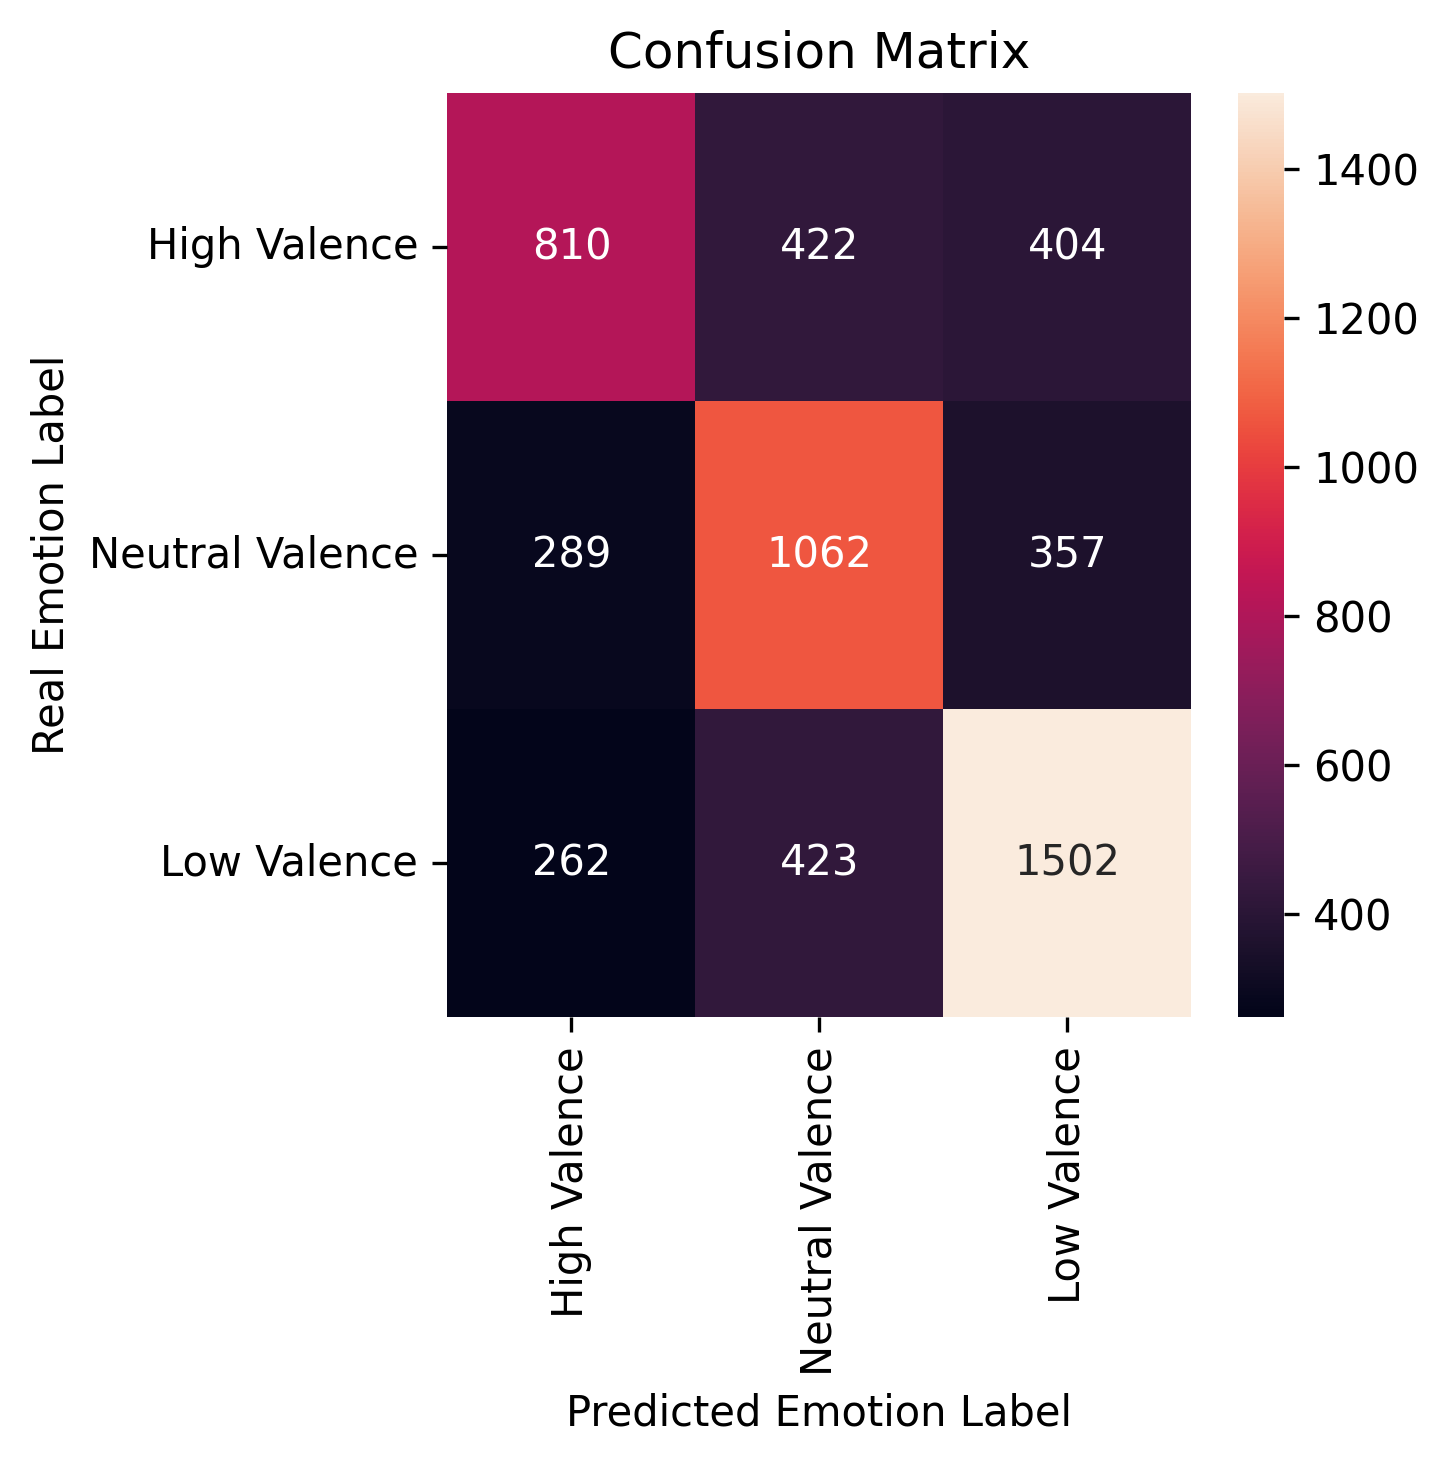

In [32]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)
df = df.sort_values(['Emotion_Id', 'Gender'], ascending = (True, True))
df = df.set_index('File')
df = df[df['Emotion'].isin({'angry', 'sad', 'neutral', 'happy', 'excited'})]
df.loc[df['Emotion_Id'] == 0, 'Emotion_Id'] = 2
df.loc[df['Emotion_Id'] == 5, 'Emotion_Id'] = 0
df.loc[df['Emotion_Id'] == 1, 'Emotion_Id'] = 0
df.loc[df['Emotion_Id'] == 3, 'Emotion_Id'] = 1

print(f"Number of Audio Files: {df.shape[0]}")
df.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']})

def get_new_model():
    return RandomForest(n_estimators=512, n_jobs=-1, random_state=1)
results = categorical_cross_validation(get_new_model, "High Valence, Neutral Valence, Low Valence", results)

Results

In [20]:
print(tabulate(results, headers=["Classification Labels", "Accuracy", "Number of Files"]))

Classification Labels               Accuracy       Number of Files
----------------------------------  -----------  -----------------
Angry, Sad, Neutral, Happy+Excited  60.26+-0.46               5531
Angry+Sad, Neutral+Happy+Excited    73.93+-1.0                5531
Angry, Happy+Excited, Sad           71.96+-1.63               3823
Angry, Happy+Excited, Neutral       65.1+-1.56                4447
Sad, Happy+Excited, Neutral         64.39+-2.13               4428
Angry, Sad, Neutral                 73.81+-1.24               3895
Angry+Sad, Happy+Excited            75.23+-0.77               3823
Angry+Sad, Happy+Excited, Neutral   61.07+-1.18               5531
Angry, Sad                          92.04+-1.18               2187
Angry, Neutral                      85.63+-1.18               2811
Angry+Sad, Happy+Excited            76.78+-1.89               2739
Sad, Neutral                        78.08+-0.86               2792
Sad, Happy+Excited                  83.93+-1.66               

# Neutral Data Analysis

## Duration

In [21]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)
df = df.sort_values(['Emotion_Id', 'Gender'], ascending = (True, True))
df = df.set_index('File')
df = df[df['Emotion'].isin({'angry', 'neutral', 'happy', 'excited', 'sad'})]
df.loc[df['Emotion_Id'] == 5, 'Emotion_Id'] = 1
df.groupby(['Emotion']).agg({'Duration': ['describe']})

Duration                                                           \
        describe                                                            
           count      mean       std     min       25%      50%       75%   
Emotion                                                                     
angry     1103.0  4.512970  3.006933  0.7600  2.435300  3.61050  5.660000   
excited   1041.0  4.780933  3.468133  0.5850  2.346100  3.82000  6.210000   
happy      595.0  4.341335  2.719494  0.8950  2.398850  3.56000  5.800000   
neutral   1708.0  3.901985  2.584867  0.7300  2.109975  3.13000  4.911875   
sad       1084.0  5.496464  4.040116  0.7642  2.680000  4.14675  7.013600   

                  
                  
             max  
Emotion           
angry    26.7730  
excited  34.1388  
happy    17.2237  
neutral  20.2900  
sad      31.9100

In [22]:
df = df[(df['Emotion_Id'] != 3) | (df["Duration"] > 1.7)]
df.groupby(['Emotion']).agg({'Duration': ['describe']})

Duration                                                        \
        describe                                                         
           count      mean       std     min      25%      50%     75%   
Emotion                                                                  
angry     1103.0  4.512970  3.006933  0.7600  2.43530  3.61050  5.6600   
excited   1041.0  4.780933  3.468133  0.5850  2.34610  3.82000  6.2100   
happy      595.0  4.341335  2.719494  0.8950  2.39885  3.56000  5.8000   
neutral   1453.0  4.347335  2.553059  1.7000  2.54540  3.53000  5.4423   
sad       1084.0  5.496464  4.040116  0.7642  2.68000  4.14675  7.0136   

                  
                  
             max  
Emotion           
angry    26.7730  
excited  34.1388  
happy    17.2237  
neutral  20.2900  
sad      31.9100

Neutral Data with more than 1.7 seconds of audio

Number of Audio Files: 5276


,,Emotion
,,count
Emotion,Emotion_Id,
angry,0,1103
excited,1,1041
happy,1,595
neutral,3,1453
sad,2,1084


Accuracy for fold 0: 59.66%
Accuracy for fold 1: 60.28%
Accuracy for fold 2: 60.95%
Accuracy for fold 3: 58.77%
Accuracy for fold 4: 60.95%

Metric             Value
-----------------  -----------
Accuracy           60.12+-0.83
F1 score macro     60.97
Precision          61.44
Recall             60.8
Matthews corrcoef  0.463


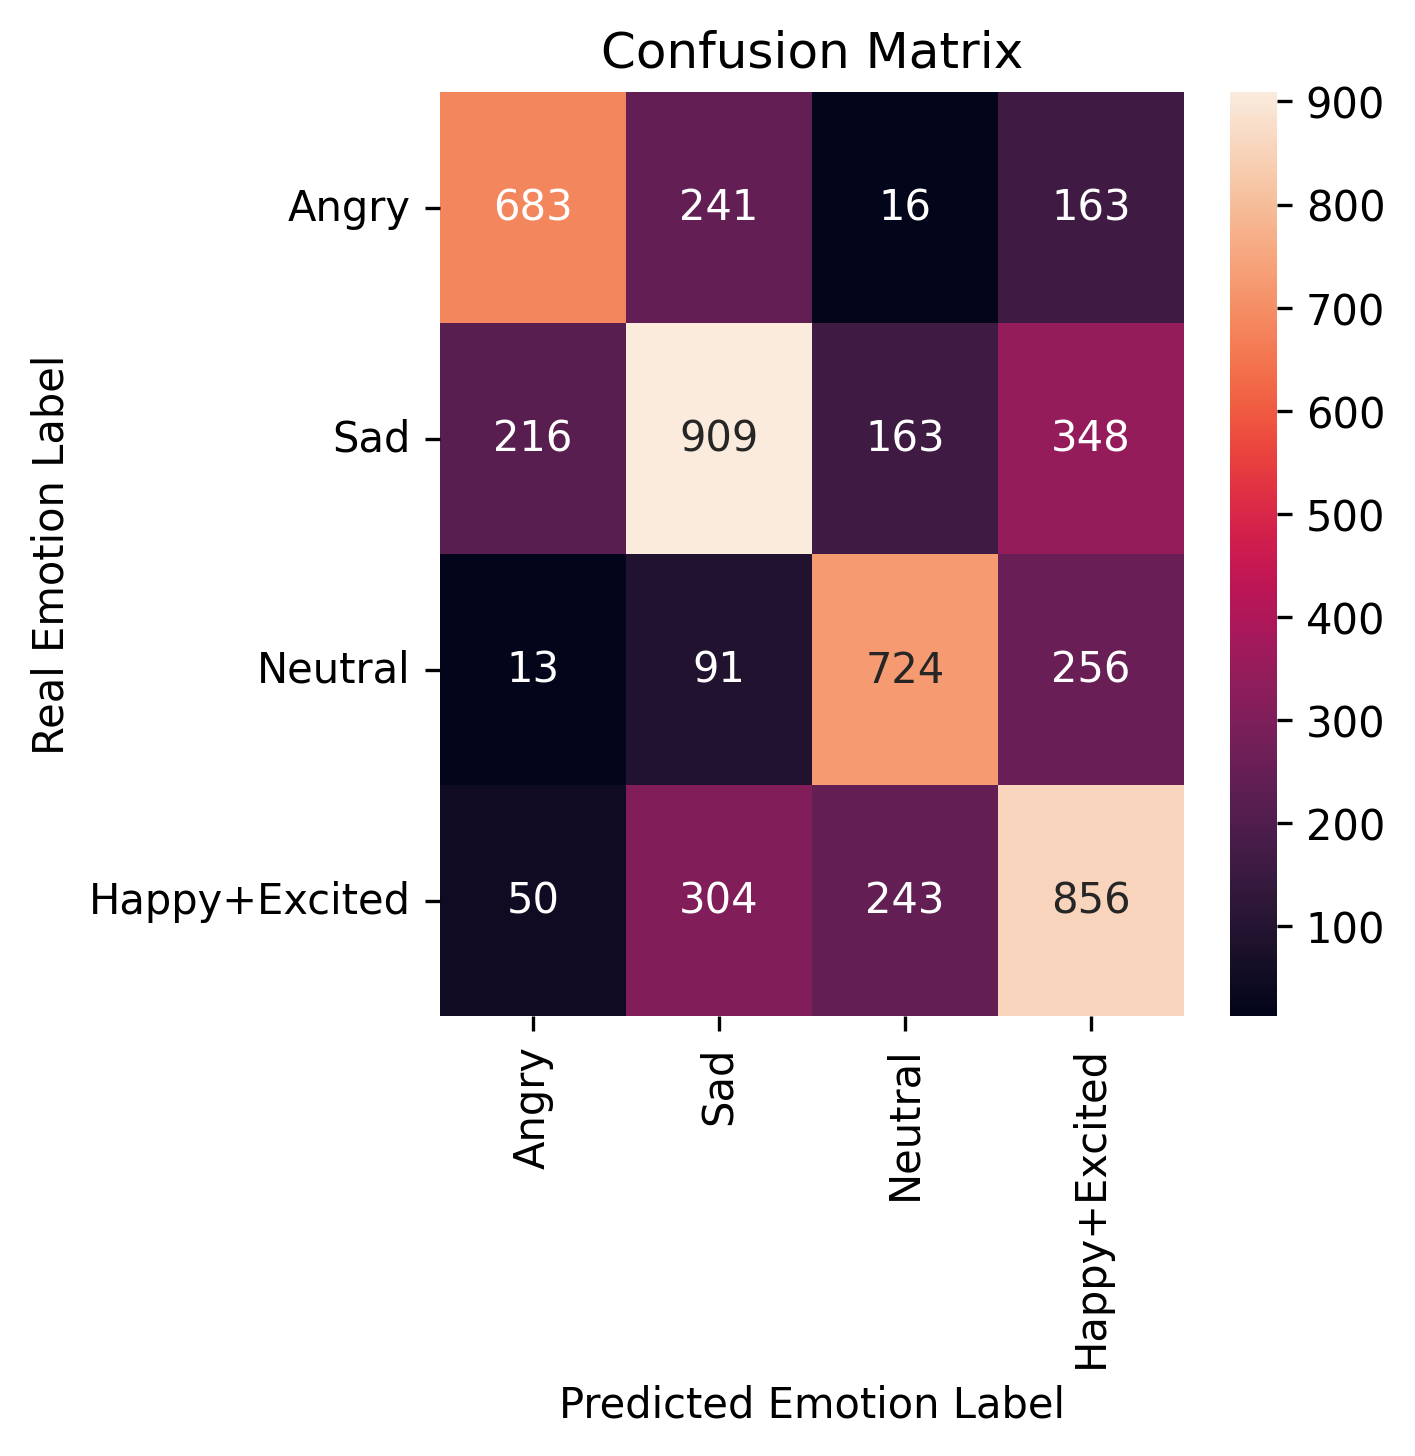

In [23]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)
df = df.sort_values(['Emotion_Id', 'Gender'], ascending = (True, True))
df = df.set_index('File')
df = df[df['Emotion'].isin({'angry', 'neutral', 'happy', 'excited', 'sad'})]
df = df[(df['Emotion_Id'] != 3) | (df["Duration"] > 1.7)]
df.loc[df['Emotion_Id'] == 5, 'Emotion_Id'] = 1

print(f"Number of Audio Files: {df.shape[0]}")
df.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']})

def get_new_model():
    return RandomForest(n_estimators=512, n_jobs=-1, random_state=1)
results = categorical_cross_validation(get_new_model, "Angry, Sad, Neutral, Happy+Excited", results)

Neutral Data with more than 1 seconds of audio

Number of Audio Files: 5515


,,Emotion
,,count
Emotion,Emotion_Id,
angry,0,1103
excited,1,1041
happy,1,595
neutral,3,1692
sad,2,1084


Accuracy for fold 0: 61.92%
Accuracy for fold 1: 59.02%
Accuracy for fold 2: 60.47%
Accuracy for fold 3: 60.2%
Accuracy for fold 4: 58.02%

Metric             Value
-----------------  -----------
Accuracy           59.93+-1.33
F1 score macro     60.62
Precision          61.64
Recall             60.16
Matthews corrcoef  0.457


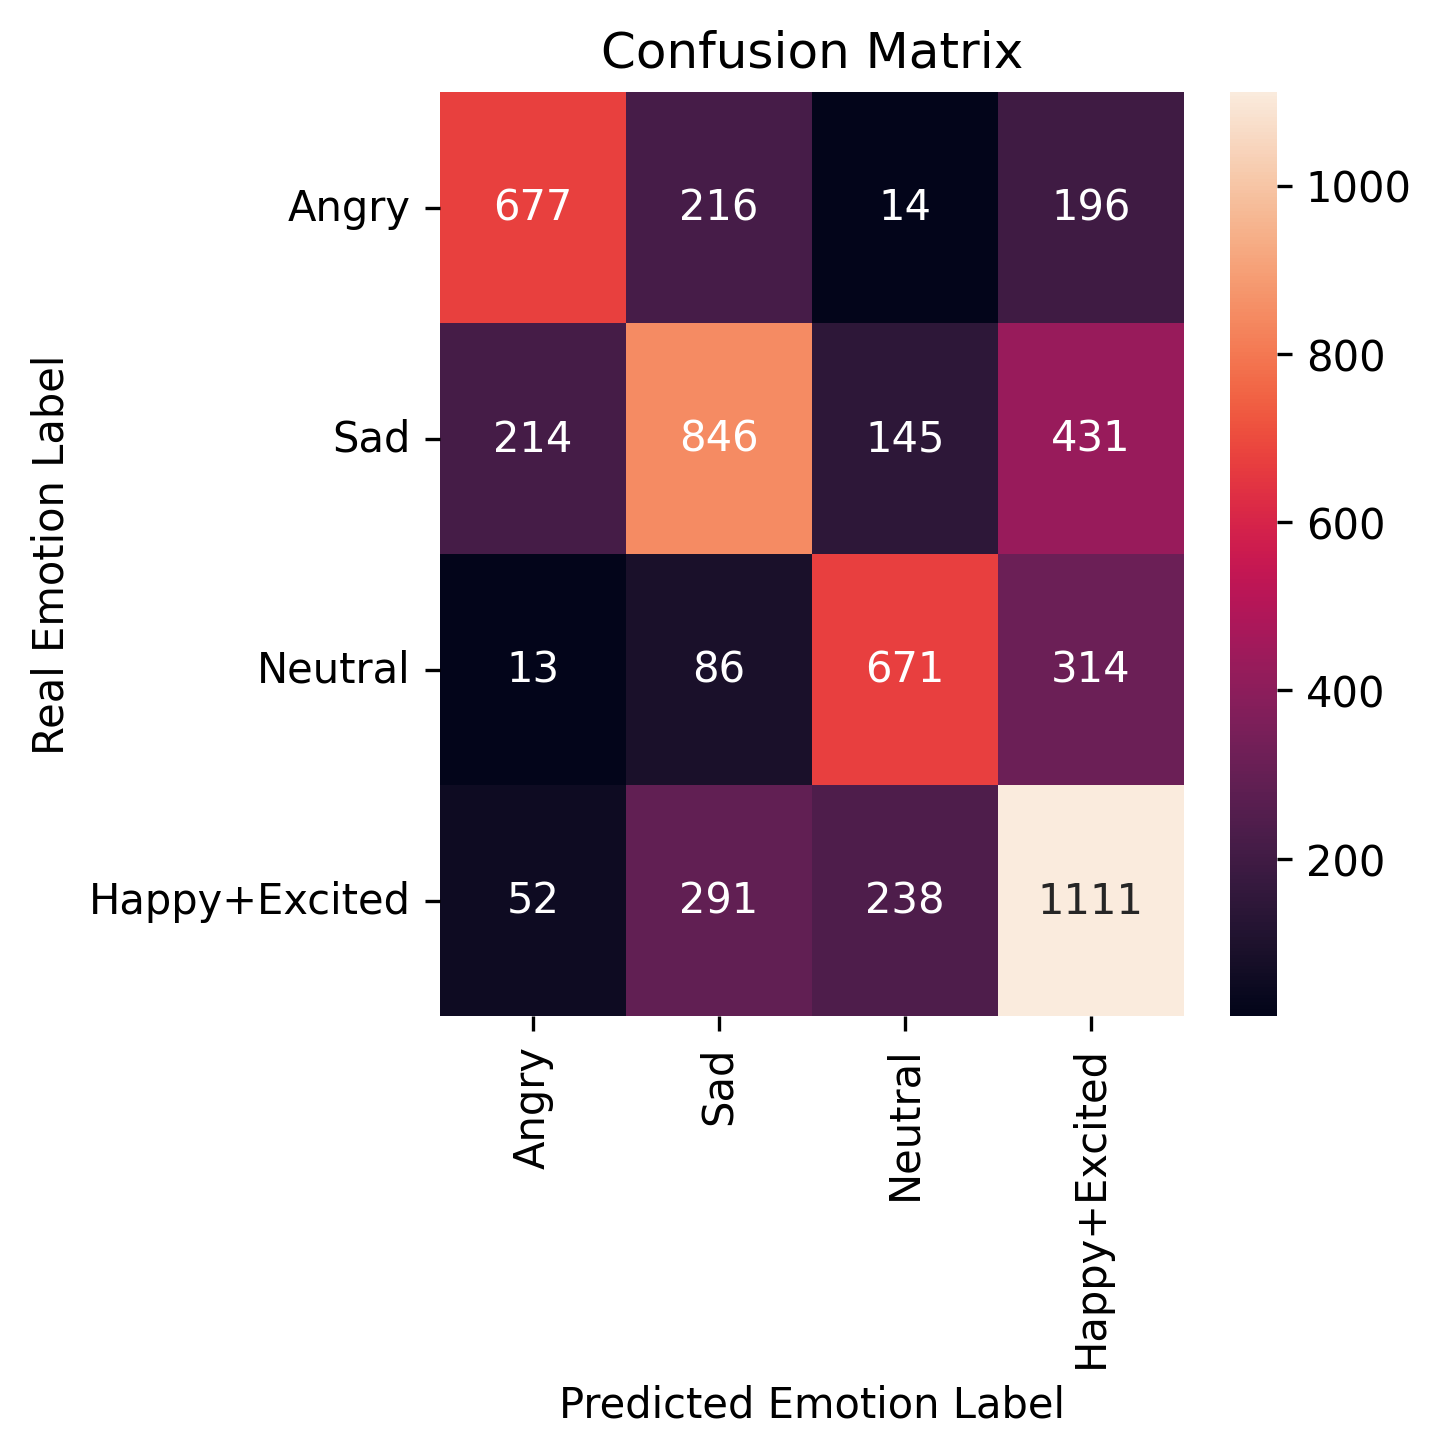

In [24]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)
df = df.sort_values(['Emotion_Id', 'Gender'], ascending = (True, True))
df = df.set_index('File')
df = df[df['Emotion'].isin({'angry', 'neutral', 'happy', 'excited', 'sad'})]
df = df[(df['Emotion_Id'] != 3) | (df["Duration"] > 1)]
df.loc[df['Emotion_Id'] == 5, 'Emotion_Id'] = 1

print(f"Number of Audio Files: {df.shape[0]}")
df.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']})

def get_new_model():
    return RandomForest(n_estimators=512, n_jobs=-1, random_state=1)
results = categorical_cross_validation(get_new_model, "Angry, Sad, Neutral, Happy+Excited", results)

Data between 1.7 and 7 seconds of audio

Number of Audio Files: 4021


,,Emotion
,,count
Emotion,Emotion_Id,
angry,0,848
excited,1,705
happy,1,450
neutral,3,1268
sad,2,750


Accuracy for fold 0: 62.24%
Accuracy for fold 1: 57.21%
Accuracy for fold 2: 56.72%
Accuracy for fold 3: 57.71%
Accuracy for fold 4: 56.84%

Metric             Value
-----------------  -----------
Accuracy           58.14+-2.08
F1 score macro     58.66
Precision          60.19
Recall             58.2
Matthews corrcoef  0.434


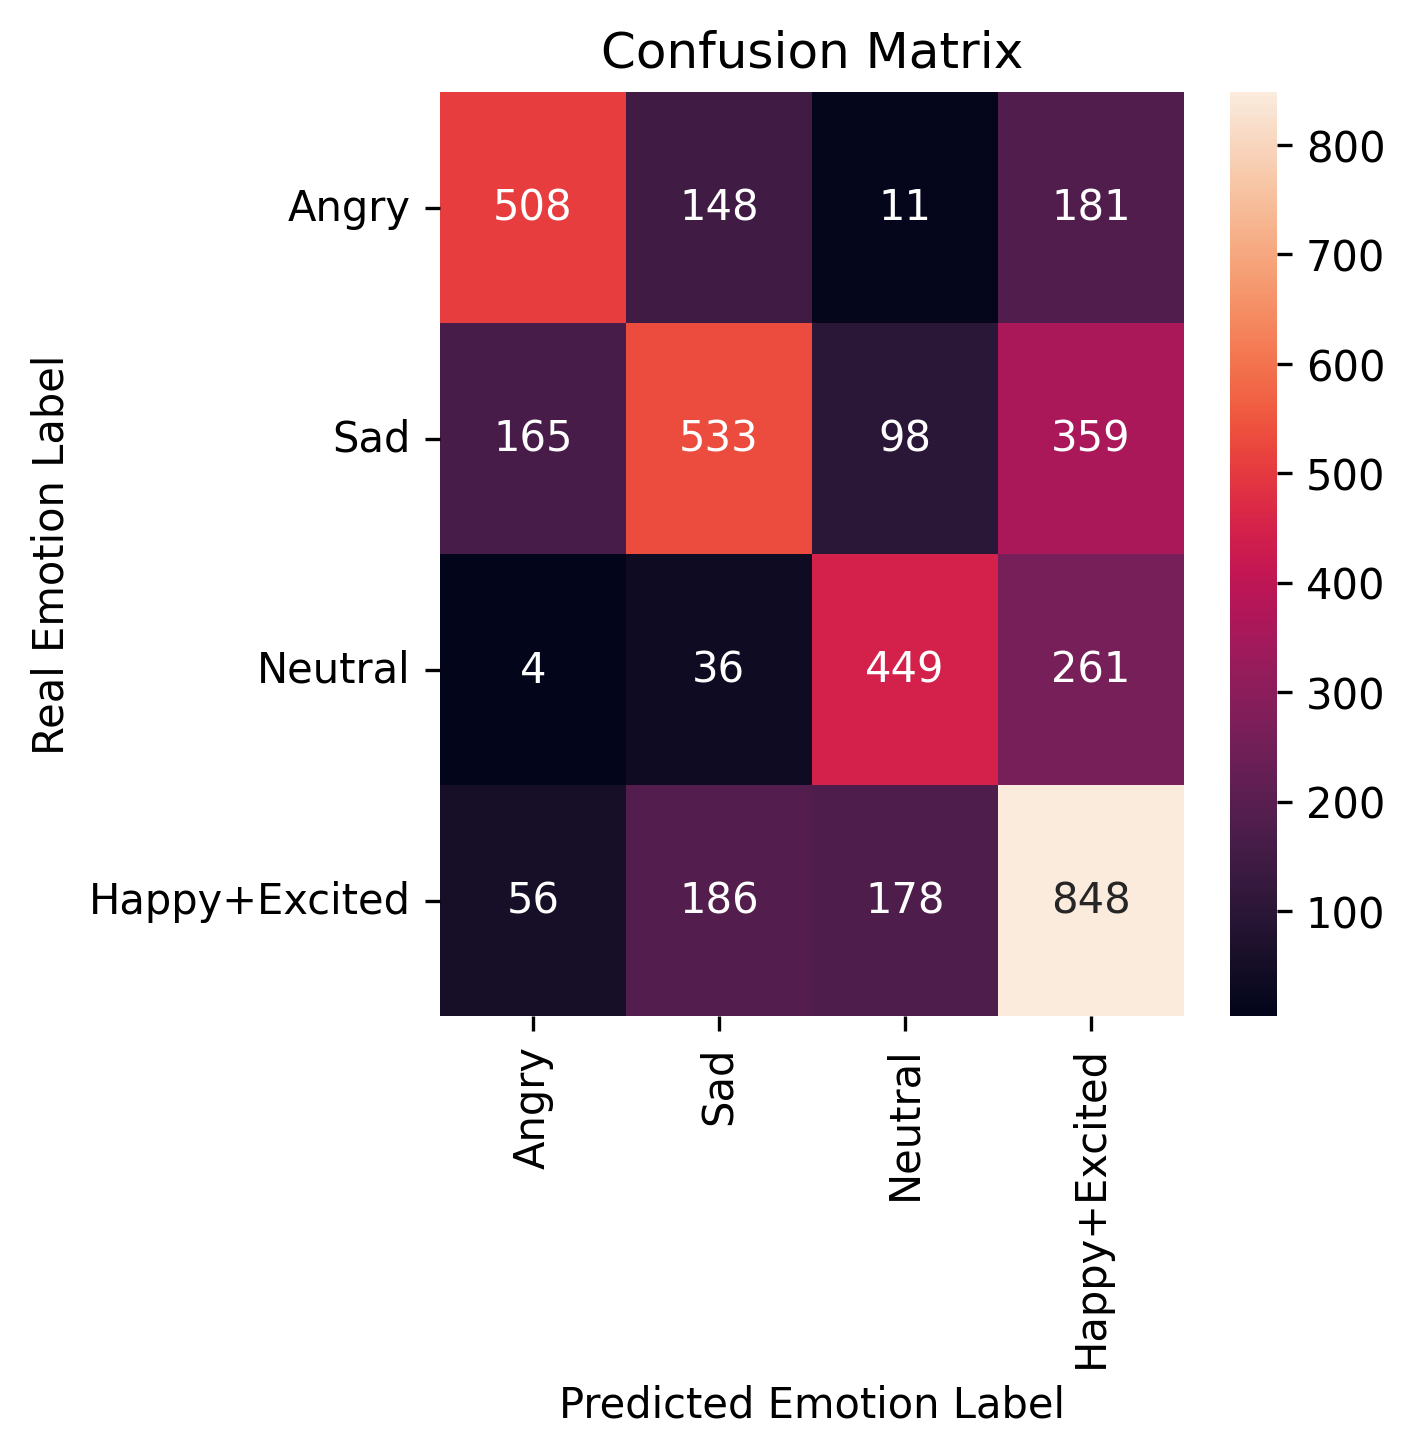

In [25]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)
df = df.sort_values(['Emotion_Id', 'Gender'], ascending = (True, True))
df = df.set_index('File')
df = df[df['Emotion'].isin({'angry', 'neutral', 'happy', 'excited', 'sad'})]
df = df[(df["Duration"] < 7) & (df["Duration"] > 1.7)]
df.loc[df['Emotion_Id'] == 5, 'Emotion_Id'] = 1

print(f"Number of Audio Files: {df.shape[0]}")
df.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']})

def get_new_model():
    return RandomForest(n_estimators=512, n_jobs=-1, random_state=1)
results = categorical_cross_validation(get_new_model, "Angry, Sad, Neutral, Happy+Excited", results)

Data between 1.7 and 8 seconds of audio

Number of Audio Files: 4257


,,Emotion
,,count
Emotion,Emotion_Id,
angry,0,892
excited,1,758
happy,1,482
neutral,3,1327
sad,2,798


Accuracy for fold 0: 58.57%
Accuracy for fold 1: 59.39%
Accuracy for fold 2: 59.93%
Accuracy for fold 3: 56.52%
Accuracy for fold 4: 56.99%

Metric             Value
-----------------  -----------
Accuracy           58.28+-1.33
F1 score macro     58.97
Precision          60.17
Recall             58.58
Matthews corrcoef  0.436


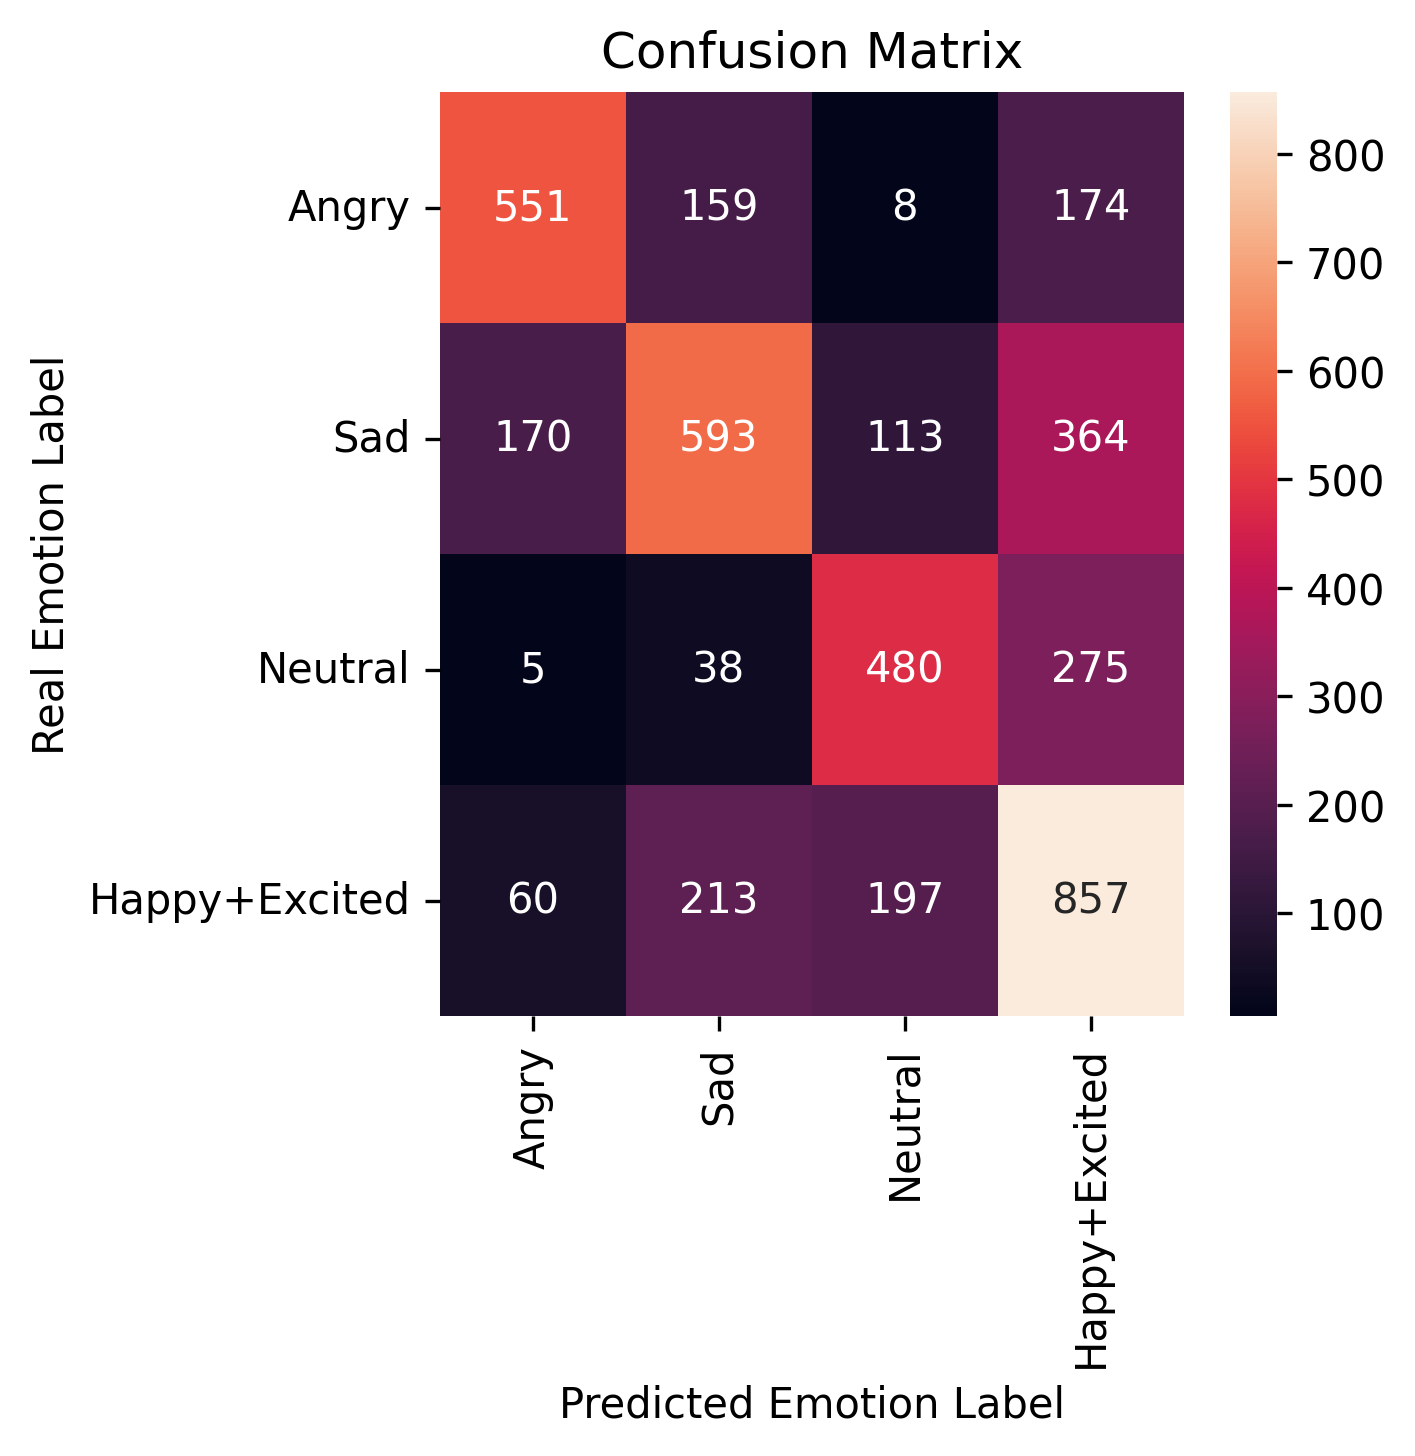

In [26]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)
df = df.sort_values(['Emotion_Id', 'Gender'], ascending = (True, True))
df = df.set_index('File')
df = df[df['Emotion'].isin({'angry', 'neutral', 'happy', 'excited', 'sad'})]
df = df[(df["Duration"] < 8) & (df["Duration"] > 1.7)]
df.loc[df['Emotion_Id'] == 5, 'Emotion_Id'] = 1

print(f"Number of Audio Files: {df.shape[0]}")
df.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']})

def get_new_model():
    return RandomForest(n_estimators=512, n_jobs=-1, random_state=1)
results = categorical_cross_validation(get_new_model, "Angry, Sad, Neutral, Happy+Excited", results)

# Logistic Regression

In [27]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)
df = df.sort_values(['Emotion_Id', 'Gender'], ascending = (True, True))
df = df.set_index('File')
df = df[df['Emotion'].isin({'angry', 'sad', 'neutral', 'happy', 'excited'})]
df.loc[df['Emotion_Id'] == 1, 'Emotion_Id'] = 0
df.loc[df['Emotion_Id'] == 5, 'Emotion_Id'] = 0
df.loc[df['Emotion_Id'] == 3, 'Emotion_Id'] = 1

print(f"Number of Audio Files: {df.shape[0]}")
df.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']})

model = LogisticRegression(n_jobs=-1, random_state=1)
model.fit(df.iloc[:,8:], df.iloc[:,4:5].values.ravel())
arousal_probabilities = model.predict_proba(df.iloc[:,8:])

final_df = df.copy(deep=True)
final_df["Low Arousal"] = [x[2] for x in arousal_probabilities]
final_df["Medium Arousal"] = [x[1] for x in arousal_probabilities]
final_df["High Arousal"] = [x[0] for x in arousal_probabilities]
final_df.groupby(['Emotion']).agg({'Low Arousal': ['describe']})
final_df.groupby(['Emotion']).agg({'Medium Arousal': ['describe']})
final_df.groupby(['Emotion']).agg({'High Arousal': ['describe']})

Number of Audio Files: 5531


,,Emotion
,,count
Emotion,Emotion_Id,
angry,0,1103
excited,0,1041
happy,0,595
neutral,1,1708
sad,2,1084


LogisticRegression(n_jobs=-1, random_state=1)

Low Arousal                                                        \
           describe                                                         
              count      mean       std           min       25%       50%   
Emotion                                                                     
angry        1103.0  0.049343  0.087974  1.975531e-47  0.002668  0.015027   
excited      1041.0  0.081971  0.094841  1.309979e-38  0.017761  0.048980   
happy         595.0  0.184871  0.176200  6.926097e-07  0.051652  0.120442   
neutral      1708.0  0.210523  0.169904  2.048974e-04  0.071904  0.157366   
sad          1084.0  0.367628  0.180120  9.008602e-04  0.221980  0.379391   

                             
                             
              75%       max  
Emotion                      
angry    0.053135  0.634976  
excited  0.113226  0.633369  
happy    0.284081  0.770336  
neutral  0.322060  0.816663  
sad      0.511387  0.750133

Medium Arousal                                                        \
              describe                                                         
                 count      mean       std           min       25%       50%   
Emotion                                                                        
angry           1103.0  0.200455  0.135302  2.572910e-59  0.086330  0.192517   
excited         1041.0  0.289712  0.130578  1.008385e-46  0.201896  0.307803   
happy            595.0  0.332995  0.099841  1.397166e-06  0.282483  0.343266   
neutral         1708.0  0.370574  0.083451  7.285114e-04  0.323294  0.370860   
sad             1084.0  0.354789  0.066027  4.088507e-02  0.313342  0.355967   

                             
                             
              75%       max  
Emotion                      
angry    0.306695  0.590533  
excited  0.378035  0.644840  
happy    0.397991  0.608142  
neutral  0.419428  0.770718  
sad      0.398331  0.666308

High Arousal                                                    \
            describe                                                     
               count      mean       std       min       25%       50%   
Emotion                                                                  
angry         1103.0  0.750201  0.197853  0.104301  0.623886  0.788957   
excited       1041.0  0.628317  0.194417  0.090314  0.489834  0.625817   
happy          595.0  0.482134  0.219858  0.061482  0.305106  0.496227   
neutral       1708.0  0.418903  0.185298  0.039717  0.271398  0.415393   
sad           1084.0  0.277583  0.169032  0.047047  0.150378  0.226888   

                             
                             
              75%       max  
Emotion                      
angry    0.909377  1.000000  
excited  0.772148  1.000000  
happy    0.641065  0.999998  
neutral  0.554473  0.999067  
sad      0.368323  0.958214

In [28]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)
df = df.sort_values(['Emotion_Id', 'Gender'], ascending = (True, True))
df = df.set_index('File')
df = df[df['Emotion'].isin({'angry', 'sad', 'neutral', 'happy', 'excited'})]
df.loc[df['Emotion_Id'] == 2, 'Emotion_Id'] = 2
df.loc[df['Emotion_Id'] == 0, 'Emotion_Id'] = 2
df.loc[df['Emotion_Id'] == 5, 'Emotion_Id'] = 0
df.loc[df['Emotion_Id'] == 1, 'Emotion_Id'] = 0
df.loc[df['Emotion_Id'] == 3, 'Emotion_Id'] = 1

print(f"Number of Audio Files: {df.shape[0]}")
df.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']})

model = LogisticRegression(n_jobs=-1, random_state=1)
model.fit(df.iloc[:,8:], df.iloc[:,4:5].values.ravel())
valence_probabilities = model.predict_proba(df.iloc[:,8:])

final_df = df.copy(deep=True)
final_df["Low Valence"] = [x[2] for x in valence_probabilities]
final_df["Medium Valence"] = [x[1] for x in valence_probabilities]
final_df["High Valence"] = [x[0] for x in valence_probabilities]
final_df.groupby(['Emotion']).agg({'Low Valence': ['describe']})
final_df.groupby(['Emotion']).agg({'Medium Valence': ['describe']})
final_df.groupby(['Emotion']).agg({'High Valence': ['describe']})

Number of Audio Files: 5531


,,Emotion
,,count
Emotion,Emotion_Id,
angry,2,1103
excited,0,1041
happy,0,595
neutral,1,1708
sad,2,1084


LogisticRegression(n_jobs=-1, random_state=1)

Low Valence                                                    \
           describe                                                     
              count      mean       std       min       25%       50%   
Emotion                                                                 
angry        1103.0  0.472771  0.164278  0.063791  0.356389  0.457900   
excited      1041.0  0.386667  0.132161  0.038068  0.300183  0.370968   
happy         595.0  0.374473  0.100966  0.129061  0.305709  0.368292   
neutral      1708.0  0.370404  0.106051  0.052409  0.300821  0.362505   
sad          1084.0  0.396055  0.080324  0.126363  0.342517  0.381904   

                             
                             
              75%       max  
Emotion                      
angry    0.577565  0.986550  
excited  0.467663  0.932596  
happy    0.436758  0.735611  
neutral  0.430624  0.755504  
sad      0.438413  0.763556

Medium Valence                                                        \
              describe                                                         
                 count      mean       std           min       25%       50%   
Emotion                                                                        
angry           1103.0  0.203600  0.117307  1.068553e-74  0.125144  0.204053   
excited         1041.0  0.271642  0.102681  2.844947e-58  0.212459  0.280626   
happy            595.0  0.317780  0.087316  1.142473e-07  0.269628  0.325647   
neutral         1708.0  0.349549  0.076477  2.793484e-04  0.295867  0.352501   
sad             1084.0  0.373022  0.070173  7.547770e-02  0.335778  0.383196   

                             
                             
              75%       max  
Emotion                      
angry    0.285338  0.534715  
excited  0.338512  0.547186  
happy    0.379130  0.521485  
neutral  0.405080  0.572870  
sad      0.418186  0.602360

High Valence                                                    \
            describe                                                     
               count      mean       std       min       25%       50%   
Emotion                                                                  
angry         1103.0  0.323629  0.134204  0.013450  0.229411  0.308574   
excited       1041.0  0.341692  0.112719  0.067404  0.265477  0.329363   
happy          595.0  0.307747  0.098859  0.114573  0.234983  0.292287   
neutral       1708.0  0.280047  0.080357  0.091588  0.225798  0.267412   
sad           1084.0  0.230923  0.043259  0.088407  0.202848  0.228079   

                             
                             
              75%       max  
Emotion                      
angry    0.397431  0.881251  
excited  0.407792  0.746998  
happy    0.365671  0.758968  
neutral  0.320105  0.683954  
sad      0.256020  0.391249

In [29]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)
df = df.sort_values(['Emotion_Id', 'Gender'], ascending = (True, True))
df = df.set_index('File')
df = df[df['Emotion'].isin({'angry', 'sad', 'neutral', 'happy', 'excited'})]
df.groupby(['Emotion']).agg({'Activation': ['describe']})
df.groupby(['Emotion']).agg({'Valence': ['describe']})
df.groupby(['Emotion']).agg({'Dominance': ['describe']})

Activation                                                
          describe                                                
             count      mean       std  min  25%     50%  75%  max
Emotion                                                           
angry       1103.0  3.635539  0.670917  1.5  3.0  3.5000  4.0  5.0
excited     1041.0  3.578370  0.608908  2.0  3.0  3.5000  4.0  5.0
happy        595.0  3.118488  0.611122  1.5  2.5  3.0000  3.5  5.0
neutral     1708.0  2.725752  0.546526  1.0  2.5  2.6667  3.0  5.0
sad         1084.0  2.563499  0.622903  1.0  2.0  2.5000  3.0  4.5

Valence                                             
        describe                                             
           count      mean       std  min  25%  50%  75%  max
Emotion                                                      
angry     1103.0  1.905712  0.524000  1.0  1.5  2.0  2.0  4.0
excited   1041.0  3.945085  0.627835  1.5  3.5  4.0  4.5  5.5
happy      595.0  3.951260  0.459555  2.0  4.0  4.0  4.0  5.0
neutral   1708.0  2.971361  0.510258  1.5  2.5  3.0  3.0  5.0
sad       1084.0  2.253075  0.580687  1.0  2.0  2.0  2.5  4.0

Dominance                                                
         describe                                                
            count      mean       std  min     25%  50%  75%  max
Emotion                                                          
angry      1103.0  3.949834  0.641306  1.0  3.5000  4.0  4.5  5.0
excited    1041.0  3.402578  0.764978  1.0  3.0000  3.5  4.0  5.0
happy       595.0  2.923809  0.658380  1.5  2.5000  3.0  3.5  5.0
neutral    1708.0  2.830553  0.606898  0.5  2.5000  3.0  3.0  4.5
sad        1084.0  2.827952  0.810631  1.0  2.3333  3.0  3.5  5.0

# Regression to Discrete

In [50]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)
df = df.sort_values(['Emotion_Id', 'Gender'], ascending = (True, True))
df = df.set_index('File')
df = df[df['Emotion'].isin({'angry', 'neutral', 'happy', 'excited', 'sad'})]
df.loc[df['Emotion_Id'] == 5, 'Emotion_Id'] = 1
print(f"Number of Audio Files: {df.shape[0]}")
df.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']})

classifier = RandomForest(n_estimators=512, n_jobs=-1, random_state=1)

classifier.fit(df.iloc[:,5:8], df.iloc[:,4:5].values.ravel())

print(f"Accuracy: {round(metrics.accuracy_score(df.iloc[:,4:5].values.ravel(), classifier.predict(df.iloc[:,5:8])) * 100, 2)}")

Number of Audio Files: 5531


,,Emotion
,,count
Emotion,Emotion_Id,
angry,0,1103
excited,1,1041
happy,1,595
neutral,3,1708
sad,2,1084


RandomForestClassifier(n_estimators=512, n_jobs=-1, random_state=1)

Accuracy: 76.32


In [93]:
def regression_cross_validation(get_new_model, used_labels, results, cv=5):
    kfold = StratifiedKFold(n_splits=cv, shuffle=True, random_state=1)

    X = df.iloc[:, 5:]
    y = df.iloc[:, 4:5]
    all_y_pred = []
    all_y_labels = []
    folds_size = []

    fold_no = 1
    for train, test in kfold.split(X, y):
        valence_model = get_new_model()
        activation_model = get_new_model()
        dominance_model = get_new_model()
        classifier = RandomForest(n_estimators=512, n_jobs=-1, random_state=1)
        
        X_train, X_test = X.iloc[train, 3:].values, X.iloc[test, 3:].values
        X_train_class = X.iloc[train, 0:3]

        y_train_valence = X.iloc[train, 0:1]
        y_train_activation = X.iloc[train, 1:2]
        y_train_dominance = X.iloc[train, 2:3]

        y_train, y_test = y.iloc[train], y.iloc[test]

        folds_size.append(len(y_test))

        valence_model.fit(X_train, y_train_valence.values.ravel())
        activation_model.fit(X_train, y_train_activation.values.ravel())
        dominance_model.fit(X_train, y_train_dominance.values.ravel())

        # should I use a classifier trained before or here
        classifier.fit(X_train_class.values, y_train.values.ravel())

        class_input = np.stack(
            (valence_model.predict(X_test),
             activation_model.predict(X_test),
             dominance_model.predict(X_test)), axis=1)
        y_pred = classifier.predict(class_input)
        all_y_pred.extend(y_pred)
        y_test = np.reshape(y_test.values, y_pred.shape)
        all_y_labels.extend(y_test)

        fold_no = fold_no + 1

    results.append([used_labels, get_metrics(
        all_y_labels, all_y_pred, folds_size, used_labels.split(", ")), len(df)])

    return results


Number of Audio Files: 5531


,,Emotion
,,count
Emotion,Emotion_Id,
angry,0,1103
excited,1,1041
happy,1,595
neutral,3,1708
sad,2,1084


1107
1107
2213
2213
3319
3319
4425
4425
5531
5531
Accuracy for fold 0: 45.89%
Accuracy for fold 1: 44.03%
Accuracy for fold 2: 42.5%
Accuracy for fold 3: 43.85%
Accuracy for fold 4: 43.76%

Metric             Value
-----------------  -----------
Accuracy           44.01+-1.09
F1 score macro     37.06
Precision          51.63
Recall             40.85
Matthews corrcoef  0.257


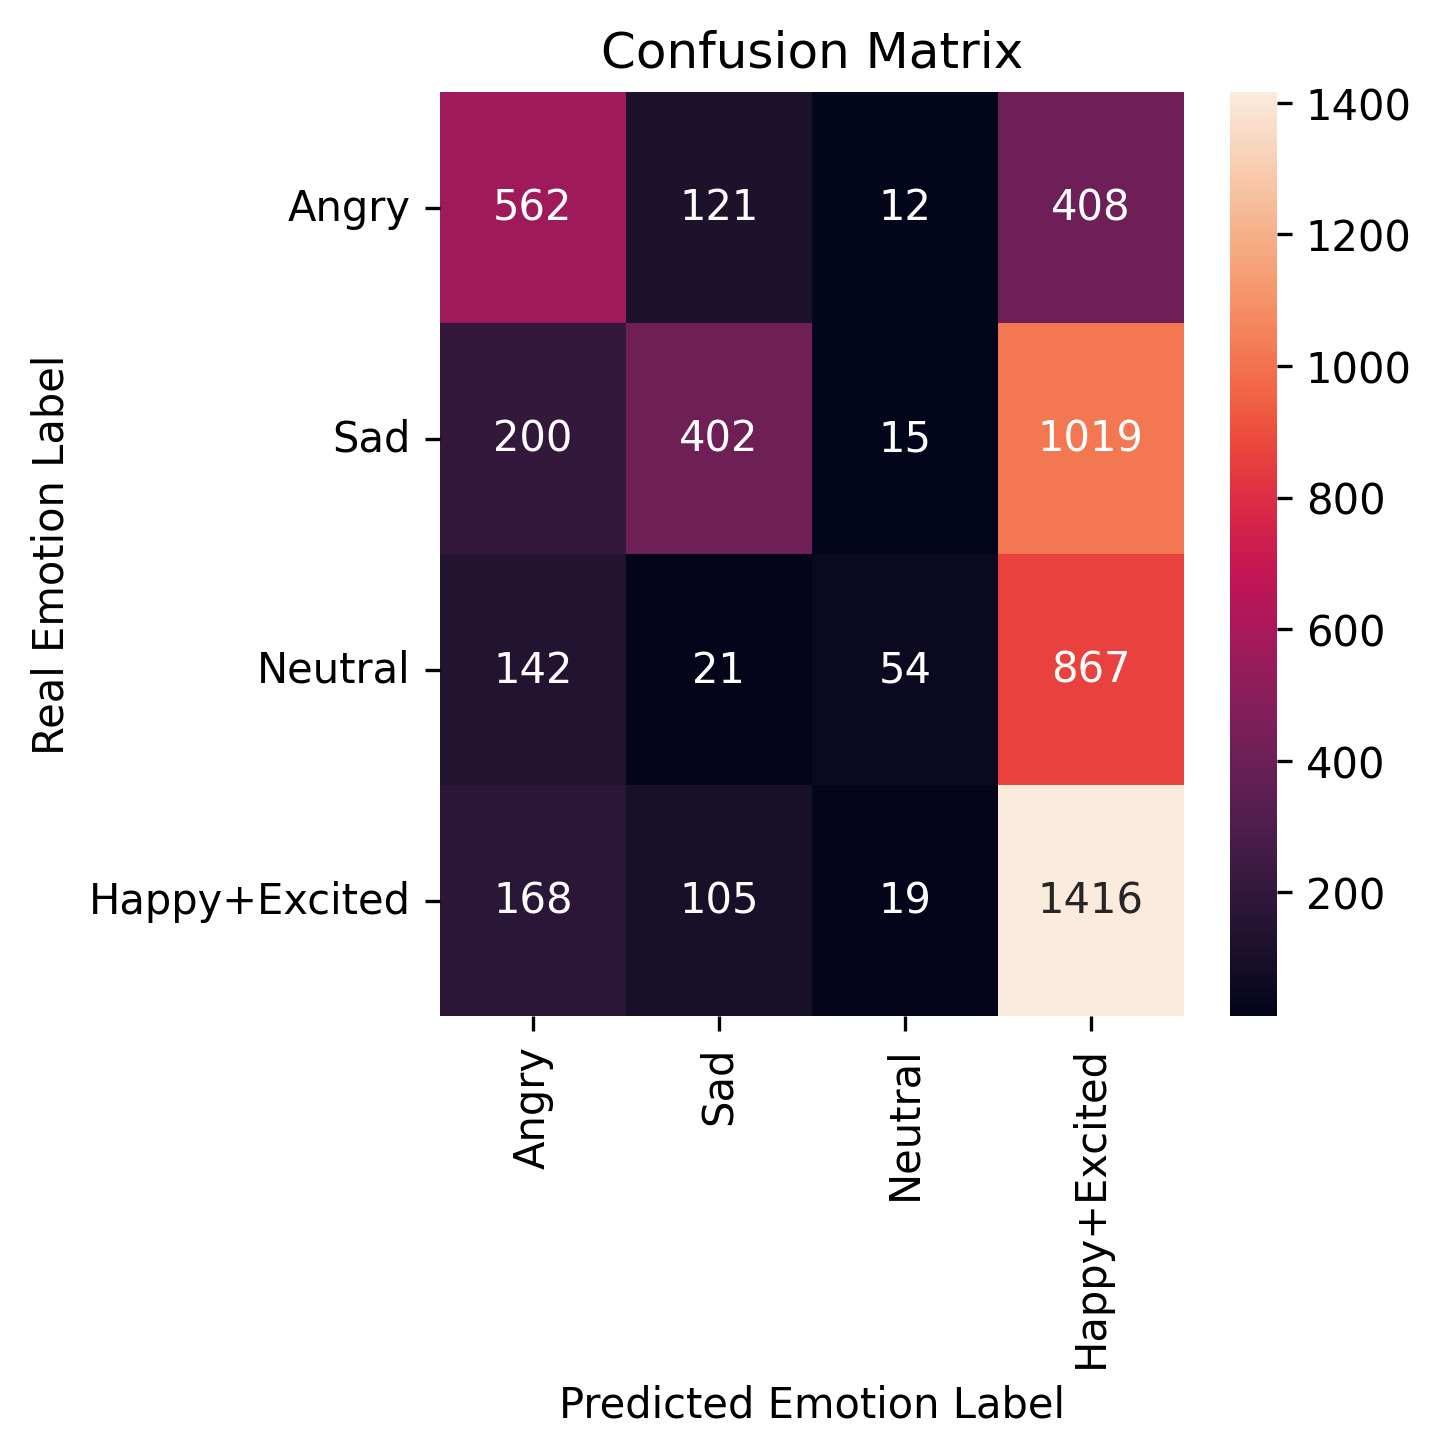

In [94]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)
df = df.sort_values(['Emotion_Id', 'Gender'], ascending = (True, True))
df = df.set_index('File')
df = df[df['Emotion'].isin({'angry', 'neutral', 'happy', 'excited', 'sad'})]
df.loc[df['Emotion_Id'] == 5, 'Emotion_Id'] = 1

print(f"Number of Audio Files: {df.shape[0]}")
df.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']})

def get_new_model():
    return RandomForestRegressor(n_estimators=512, n_jobs=-1, random_state=1)

results = regression_cross_validation(get_new_model, "Angry, Sad, Neutral, Happy+Excited", results)